In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss

from IPython.display import display, Math, Latex

def caterpillar_data():
    """
    Cette fonction charge le jeu de données sur les chenilles processionnaires du
    pin et retourne un tuple composé des objets suivants :
      X : matrice des variables explicatives
      y : vecteur réponse
    """
    # Chargement des données
    caterpillar = pd.read_csv("data.csv")
    # Matrice des variables explicatives
    X = caterpillar.iloc[:, :8].values
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    # Vecteur réponse
    y = caterpillar.y.values
    return X, y

def simu_data(n, beta, sigma2, f=lambda p: np.random.normal(size=p)):
    """
    Cette fonction permet de simuler un jeu de données de taille n correspondant à
    un modèle linéaire gaussien ordinaire de paramètres beta et sigma2. Les
    variables explicatives sont générées à l'aide de la fonction f sous la forme
    d'un vecteur de taille beta.shape[0] - 1 (supposé strictement positif) auquel on
    adjoint la constante 1 pour la première composante. Par défaut, f génère un
    vecteur gaussien standard.
    La fonction retourne un tuple composé des objets suivants :
      X : matrice des variables explicatives
      y : vecteur réponse
    """
    # Nombre de variables explicatives
    p = beta.shape[0] - 1
    assert p > 0
    # Matrice des variables explicatives
    X = np.ones((n, p + 1))
    for i in range(n): X[i, 1:] = f(p)
    # Vecteur réponse
    y = X.dot(beta) + np.random.normal(size=n, scale=np.sqrt(sigma2))
    return X, y

<h1 class="text-center">BE de statistique bayésienne – 17/02/2023</h1>

<br/>

<div class="jumbotron text-center"><b>Le but du BE est d'utiliser les résultats du cours de statistique bayésienne pour estimer les coefficients d'une régression linéaire dans un cadre gaussien et établir des intervalles de confiance sur ces coefficients.</b></div>

<h1>I. Préliminaires</h1>

<h2>Jeu de données</h2>

Les données que nous manipulerons dans la suite du BE proviennent d'une étude de 1973 sur les chenilles processionnaires du pin. Elles ont été publiées et étudiées dans un article de Tomassone *et al.* en 1993. Les mesures considérées permettent d'évaluer l'influence de certaines caractéristiques forestières sur le développement des colonies de chenilles.

Nous disposons de $n=33$ observations des variables quantitatives suivantes :
  * $x^1$ altitude (en mètres),
  * $x^2$ pente (en degrés),
  * $x^3$ nombre de pins dans la parcelle,
  * $x^4$ hauteur (en mètres) de l'arbre choisi au centre de la parcelle,
  * $x^5$ orientation de la parcelle (de $1$ vers le sud à $2$ sinon),
  * $x^6$ hauteur (en mètres) de l'arbre dominant,
  * $x^7$ nombre de couches de végétation,
  * $x^8$ indice de mélange de la colonie (de $1$ si pas de mélange à $2$ sinon),
  * $y$ transformation logarithmique du nombre moyen de nids de chenilles par arbre.

La variable $y$ que nous cherchons à expliquer est appelée la **réponse** et les variables $x^1, \dots, x^p$ sont les $p=8$ **variables explicatives**. Le vecteur des observations d'une variable est noté en gras dans la suite. Ainsi, $\mathbf{y} = (y_1, \dots, y_n)^\top \in \mathbb{R}^n$ désigne les observations de la réponse $\mathbf{y}$ et, pour tout $k \in \{1, \dots, p\}$, $\mathbf{x^k} = (x^k_1, \dots, x^k_n)^\top \in \mathbb{R}^n$ désigne les observations de la variable explicative $x^k$. Nous introduisons la **matrice des variables explicatives** $X$ de taille $n \times (p+1)$ définie par

\begin{equation*}
X = \begin{bmatrix} \mathbf{1_n} & \mathbf{x^1} & \dots & \mathbf{x^p} \end{bmatrix}
  = \begin{bmatrix}
      1 & x^1_1 & x^2_1 & \dots & x^p_1\\
      1 & x^1_2 & x^2_2 & \dots & x^p_2\\
      \vdots & \vdots & \vdots & \vdots & \vdots\\
      1 & x^1_n & x^2_n & \dots & x^p_n
    \end{bmatrix}
\end{equation*}

L'objectif statistique est de proposer une représentation de la densité conditionnelle $f(\mathbf{y} \mid X, \theta)$ de la réponse $\mathbf{y}$ sachant les observations $X$ et un paramètre $\theta$ à définir. Sans hypothèse supplémentaire, l'estimation de cette fonction est généralement impossible mais la statistique bayésienne nous offre des outils pour estimer le paramètre $\theta$ dans le cadre de modèles spécifiques.

<p class="bg-primary" style="padding:1em"><strong>QUESTION I.1.</strong> Exécutez le code suivant pour charger le jeu de données. Que fait la fonction <b>scatter</b>? Quels premiers commentaires pouvez-vous faire sur les liens entre les variables explicatives et la réponse?</p>

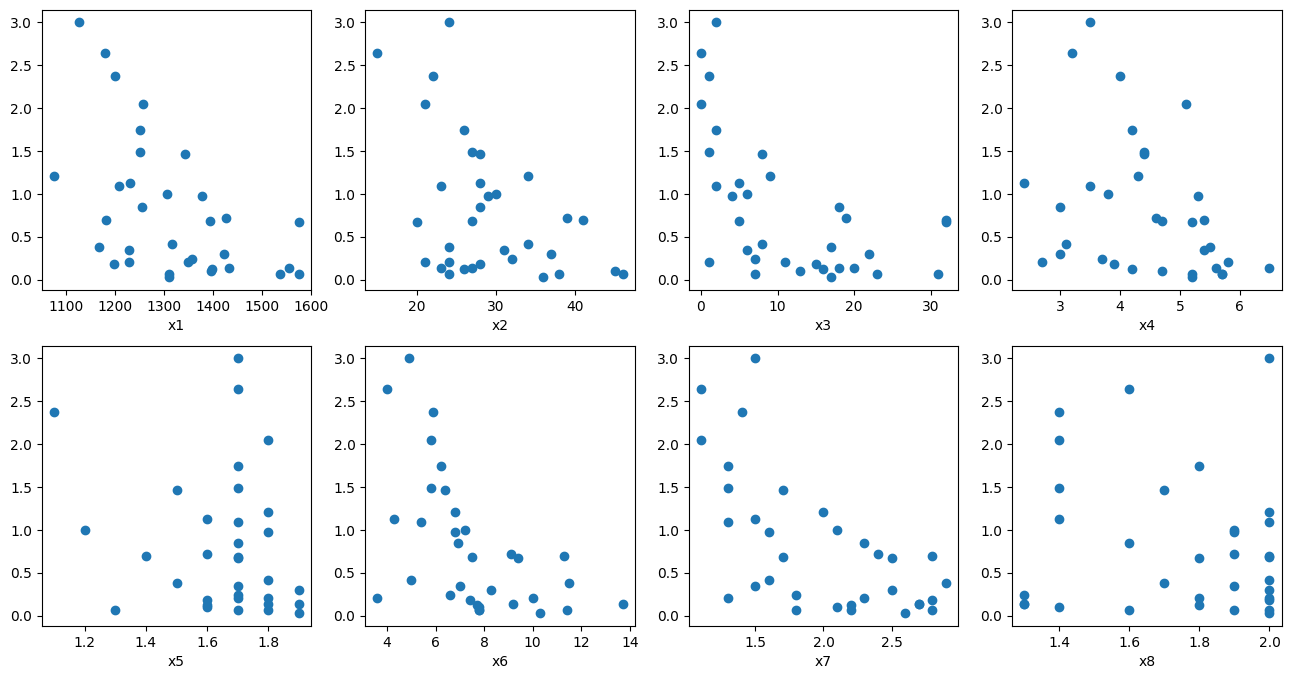

In [2]:
# Chargement des données
Xc, yc = caterpillar_data()

# Figures
fig = plt.figure(figsize=(16, 8))
for i in range(1, 9):
    sp = fig.add_subplot(2, 4, i)
    sp.scatter(Xc[:, i], yc)
    sp.set_xlabel('x' + str(i))

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION I.1.</strong>La fonction scatter permet d'afficher des graphiques en nuages de points. On peut remarquer que les variables $x1$, $x2$, $x3$, $x6$ et $x7$ semblent corrélées négativement avec avec la réponse $y$</div>

<h2>Modèle linéaire gaussien ordinaire</h2>

Dans le cadre du BE, nous ne considérerons que le **modèle linéaire gaussien ordinaire** qui est le modèle paramétré par $(\beta, \sigma) \in \mathbb{R}^{p+1} \times \mathbb{R}_+$ où pour $\beta$ et $\sigma$ (et $X$) donnés, $\mathbf{y}$ suit une loi normale de moyenne $X \beta$ et de variance $\sigma^2 I_n$ avec $I_n$ la matrice identité de taille $n \times n$:
$$
\mathbf{y} \mid X, \beta, \sigma^2 \sim \mathcal{N}_n(X\beta, \sigma^2 I_n).
$$
Dans ce modèle, les réponses sont des fonctions linéaires des entrées, perturbées par un bruit blanc centré et de variance $\sigma^2$, le bruit étant indépendant d'une observation à l'autre. On a en particulier
$$
\mathbb{E}(y_i \mid X, \beta, \sigma^2) = \beta_0 + \beta_1 x^1_i + \cdots + \beta_p x^p_i \ \text{ et } \ \mathbb{V}(y_i \mid X, \beta, \sigma^2) = \sigma^2
$$
On remarque que la colonne $\mathbf{1}_n$ de la matrice $X$ permet d'introduire l'ordonnée à l'origine $\beta_0 \in \mathbb{R}$ tout en conservant des notations cohérentes vis-à-vis de la moyenne conditionnelle $X\beta$ du vecteur gaussien $\mathbf{y}$.

Avant de développer l'approche bayésienne, nous rappelons comment la statistique fréquentiste aborde l'estimation du vecteur $\beta$ des **coefficients de régression** et de la variance $\sigma^2$ par maximum de vraisemblance.

<p class="bg-primary" style="padding:1em"><strong>QUESTION I.2.</strong> Donnez la vraisemblance $\ell(\beta, \sigma^2 \mid \mathbf{y}, X)$ du modèle considéré. En utilisant le DM et en supposant $X^\top X$ inversible, donnez l'estimateur du maximum de vraisemblance de $\beta$ à $\sigma^2$ donné, que l'on notera $\hat \beta_{\text{MV}}$ par la suite.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION I.2.</strong> <br>La vraisemblance vaut 
\begin{equation*}
\ell(\beta \mid \mathbf{y}, X) = \frac{1}{(2 \pi \sigma^2)^{\frac{n}{2}}}\exp\left( -\frac{1}{2\sigma^2} \lVert  (y - X\beta) \rVert^2 \right)   
\end{equation*}<br>
On trouve $\hat \beta_{MV}=(X^TX)^{-1}X^Ty$</div>


<p id="beta_mv" class="bg-primary" style="padding:1em"><strong>QUESTION I.3.</strong> Vérifiez que $\hat \beta_{\text{MV}}$ est sans biais pour estimer $\beta$ et que $\mathbb{V}(\hat{\beta}_{\text{MV}} \mid X, \sigma^2) = \sigma^2 (X^\top X)^{-1}$.<br/></p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION I.3.</strong><br>On cherche à montrer que $\mathbb{E}(\hat \beta_{MV} - \beta)=0$<br>$\mathbb{E}(\hat \beta_{MV}-\beta)=(X^TX)^{-1}X^T\mathbb{E}(y) - \beta$<br>Or $\mathbb{E}(y)=X\beta$<br>Donc $\mathbb{E}(\hat \beta_{MV}-\beta)=(X^TX)^{-1}X^TX\beta-\beta = 0$<br>On vient de montrer que $\hat \beta_{MV}$ est sans biais pour estimer $\beta$.
<br><br>$\mathbb{V}(\hat \beta_{MV})=\mathbb{V}((X^TX)^{-1}X^Ty \mid \sigma^2,\beta,X)$
<br>      $=(X^TX)^{-1}X^T\mathbb{V}(Y)((X^TX)^{-1}X^T)^T$
<br>      $=\sigma^2(X^TX)^{-1}X^TX((X^TX)^{-1})^T$
<br>      $=\sigma^2((X^TX)^T)^{-1}$ car $((X^TX)^{-1})^T=((X^TX)^T)^{-1}$
<br>      $=\sigma^2(X^TX)^{-1}$</div>

De même, il est possible d'estimer la variance $\sigma^2$ dans un modèle linéaire gaussien ordinaire par maximum de vraisemblance. Si $X^\top X$ est inversible et $p + 1 < n$, nous obtenons ainsi l'estimateur sans biais de $\sigma^2$ suivant,

\begin{equation*}
{\hat{\sigma}}_{\text{MV}}^2 = \frac{1}{n - p - 1} \lVert \mathbf{y} - X\hat{\beta}_{\text{MV}} \rVert^2.
\end{equation*}

Les éléments du vecteur $\mathbf{y} - X\hat{\beta}_{\text{MV}}$ sont appelés les **résidus** et nous noterons $s^2 = \lVert \mathbf{y} - X\hat{\beta}_{\text{MV}} \rVert^2$ dans la suite.</div>

<p id="qi4" class="bg-primary" style="padding:1em"><strong>QUESTION I.4.</strong> Complétez et expliquez ce que fait le code suivant, en particulier les fonctions <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html" style="color:white"><b>gaussian_kde</b></a> et <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html" style="color:white"><b>kstest</b></a>, puis répondez aux questions.<br/><br/>
● Que vaut l'estimateur de la variance $\hat{\sigma}_{\text{MV}}^2$ pour le jeu de données sur les chenilles processionnaires?<br />
● Comment pouvons-nous obtenir une prédiction de la réponse $\mathbf{y}$ à partir de l'estimateur $\hat{\beta}_{\text{MV}}$ et d'une nouvelle observation des variables $x^1, \dots, x^p$?<br />
● Quelle est la loi attendue des résidus ? Expliquez ce que représente la figure et commentez-la.</p>

sigma chenille: 0.31255772331650933


KstestResult(statistic=0.2696824643863983, pvalue=0.013071973690634842)

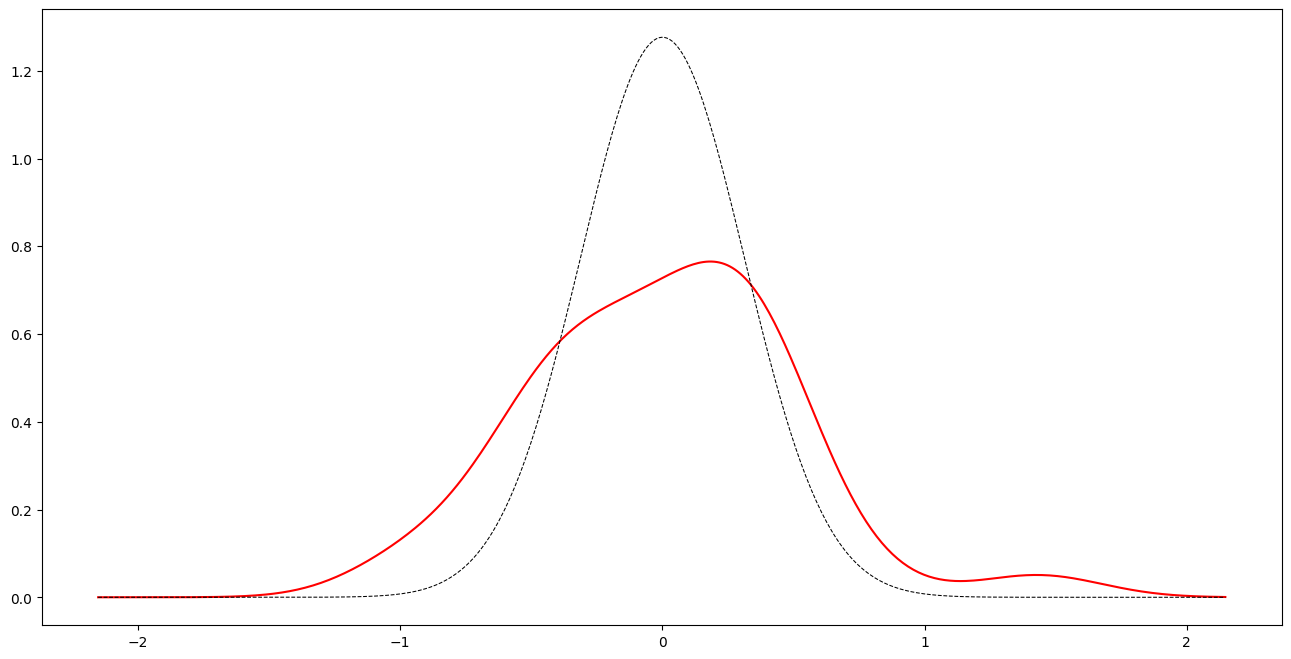

In [3]:
# Estimateurs du maximum de vraisemblance
betac_mv = np.dot(np.dot(np.linalg.inv(np.dot(Xc.T, Xc)), Xc.T), yc) # TO DO calcul de l'estimateur du maximum de vraisemblance
rc_mv = yc - np.dot(Xc,betac_mv) # TO DO calcul des résidus
sigma2c_mv = (np.linalg.norm(rc_mv)**2)/ (Xc.shape[0] - Xc.shape[1])  # TO DO calcul de l'estimateur de la variance
print("sigma chenille:", sigma2c_mv)
# Figure
borne = np.max(abs(rc_mv))
t = np.arange(-1.5 * borne, 1.5 * borne, 0.01)

densite = ss.gaussian_kde(rc_mv) # TO DO quel(s) paramètres passer à la fonction gaussian_kde ?
normale = ss.norm(scale=sigma2c_mv) # TO DO quel(s) paramètres passer à la fonction ss.norm ?

plt.figure(figsize=(16, 8))
_ = plt.plot(t, densite(t), 'r-')
_ = plt.plot(t, normale.pdf(t), 'k--', linewidth=0.75)

ss.kstest(rc_mv, "norm")

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION I.4.</strong> On trouve $\hat \sigma_{MV}^2=0.313$<br><br>
On peut obtenir une prédiction de la réponse $y$ avec les données $X$ à partir de cette loi:
$y=X.\hat \beta_{MV}$ 
    
La loi attendue des résidus est une loi gaussienne centrée de variance $\sigma^2$.
    
En pointillés on a la loi normale de variance $\hat \sigma_{MV}^2$, et en rouge l'estimation de la densité des résidus avec un kernel gaussien.<br>Le test réalisé sur la normalité des résidus a une $p-value < 0.05$ donc on peut bien affirmer la normalité des résidus.</div>

En pratique, pour savoir si la matrice $X^\top X$ est inversible, nous pouvons vérifier la condition équivalente : la matrice $X$ est de rang plein, i.e., ses colonnes forment une famille libre dans $\mathbb{R}^n$. Si tel n'est pas le cas, l'estimateur du maximum de vraisemblance n'est pas unique et la formule donnée dans la [question I.2](#beta_mv) pour $\hat{\beta}_{\text{MV}}$ n'est plus valable. Plus généralement, le problème se pose si certaines colonnes de $X$ sont proches de la colinéarité car cela induit une forte instabilité de l'estimateur du maximum de vraisemblance à cause de sa structure de variance $\mathbb{V}(\hat{\beta}_{\text{MV}} \mid X, \sigma^2)$ proche d'un état dégénéré.

Une façon de contourner ces difficultés et de stabiliser l'estimateur du maximum de vraisemblance consiste à considérer une version régularisée du critère des moindres carrés en ajoutant une contrainte sur la norme de $\beta$,
\begin{equation*}
\min_{\beta \in \mathbb{R}^{p+1}} \left\{ \lVert \mathbf{y}-X\beta \rVert^2 + \lambda \lVert \beta \rVert^2 \right\}
\end{equation*}
où $\lambda > 0$ est un paramètre de régularisation idéalement petit.

<p class="bg-primary" style="padding:1em"><strong>QUESTION I.5.</strong> En donnant le gradient de la fonction $\beta \mapsto \lVert \mathbf{y}-X\beta \rVert^2 + \lambda \lVert \beta \rVert^2$, montrez que ce problème de minimisation revient à résoudre le système linéaire $(X^\top X + \lambda I_{p + 1})\beta = X^\top \mathbf{y}$. Expliquez pourquoi la matrice $X^\top X + \lambda I_{p + 1}$ est inversible et déduisez-en que l'estimateur de $\beta$ obtenu s'écrit<br/><br/>
\begin{equation*}
\hat{\beta}_{\text{R}, \lambda} = (X^\top X + \lambda I_{p + 1})^{-1} X^\top \mathbf{y}.
\end{equation*}<br/>
Cet estimateur $\hat{\beta}_{\text{R}, \lambda}$ est appelé <b>estimateur ridge</b> de paramètre $\lambda$.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION I.5.</strong> <br>Le gradient de la fonction ci-dessus (que l'on note $J$) est:
\begin{equation*}
\nabla J(\beta) = 2 X^\top X \beta - 2 X^\top y + 2\lambda \beta 
\end{equation*}
Si on cherche à annuler ce gradient on a : 
\begin{equation*}
\nabla J(\beta) = 0  \iff  2 X^\top X \beta - 2 X^\top y + 2\lambda \beta = 0 \iff \beta = (X^\top X + \lambda I_{p+1})^{-1} X^\top y
\end{equation*}
On sait que $X^\top X$ est symétrique et positive et $\lambda >0$ donc $\lambda I_{p+1}$ est définie positive. D'après la question III.1 du DM on a $X^\top X + \lambda I_{p + 1}$ inversible. 
</div>

<h2>Données simulées</h2>

Afin de pouvoir étudier le rôle de certains paramètres dans la suite du BE, nous ne nous limiterons pas à un seul jeu de données de taille fixe. De plus, pour mesurer les performances des procédures statistiques considérées, nous aurons besoin de connaître la véritable cible que nous cherchons à estimer. Ainsi, la fonction `simu_data` définie en préambule nous permettra de générer des données issues d'un modèle linéaire gaussien ordinaire pour leur appliquer les différentes méthodes d'estimation.

<p class="bg-primary" style="padding:1em"><strong>QUESTION I.6.</strong> Complétez et exécutez le code suivant pour se familiariser avec la génération de données simulées, puis répondez aux questions.<br/><br/>
    &#9679; Faites varier le paramètre <b>lambda_max</b>. Comment évoluent les estimateurs ridge lorsque $\lambda$ augmente?<br/>
&#9679; Faites varier l'ordre de grandeur des coefficients et de la variance dans le modèle linéaire gaussien ordinaire. Observez-vous un changement de comportement des estimateurs ridge?<br/>
    &#9679; Faites varier la taille <b>n</b> du jeu de données simulées. Observez-vous un changement de comportement des estimateurs ridge?</p>

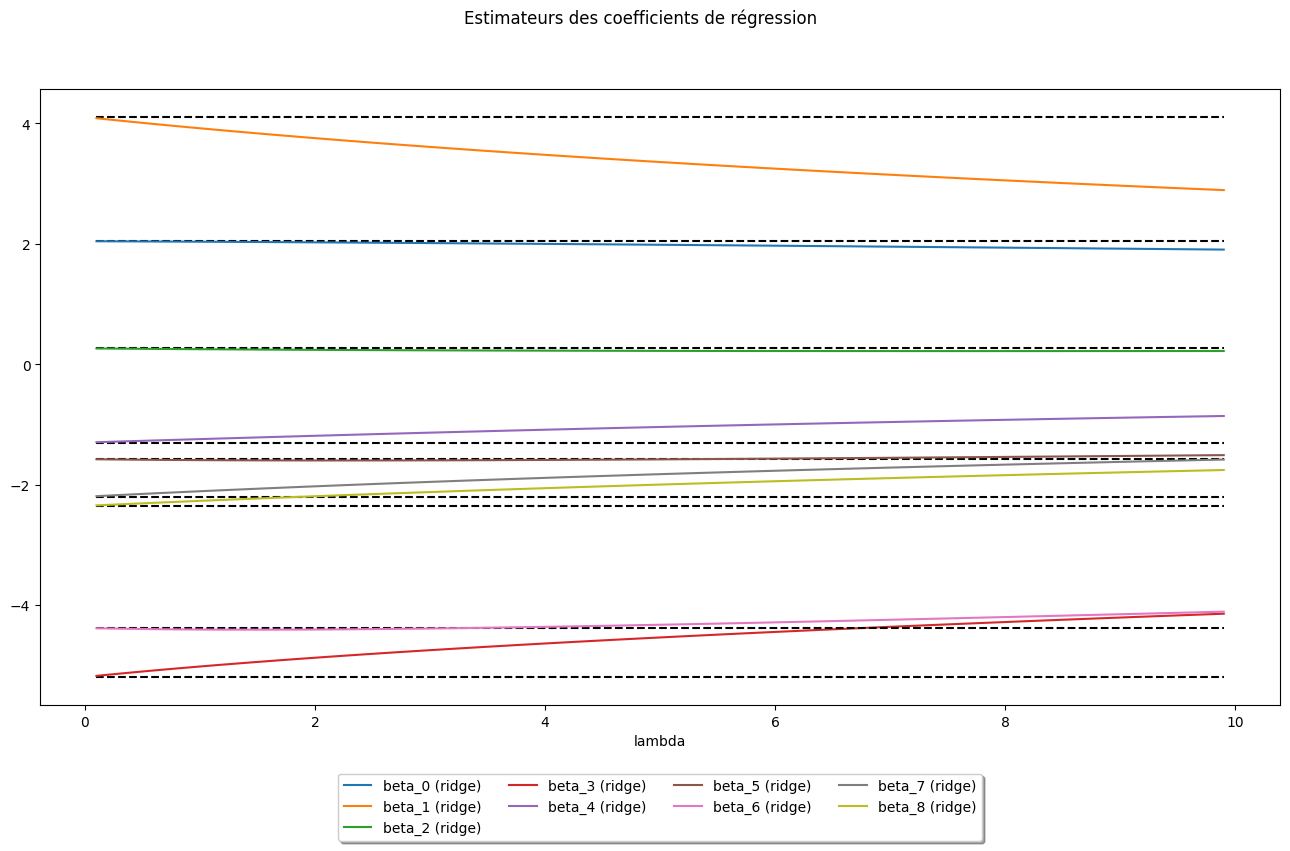

In [4]:
# Paramètres de la simulation
n, p = 33, 8
sigma2 = 1.0
odg = 5.0
beta = np.random.uniform(-odg, odg, p + 1)

# Génération des données
Xs, ys = simu_data(n, beta, sigma2)

# Estimateur du maximum de vraisemblance
beta_mv = np.dot(np.dot(np.linalg.inv(np.dot(Xs.T, Xs)), Xs.T), ys)

# TO DO calcul de l'estimateur du maximum de vraisemblance

# Estimateurs ridge pour différentes valeurs du paramètre
lambda_max = 10.0
lambdas = np.arange(0.1, lambda_max, 0.1)
beta_r = np.zeros((lambdas.shape[0], p + 1))
for i in range(lambdas.shape[0]):
    beta_r[i, :] = np.dot(np.dot(np.linalg.inv(np.dot(Xs.T,Xs)+ lambdas[i]*np.identity(p+1)), Xs.T), ys)             # TO DO calcul de l'estimateur Ridge

# Figure
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Estimateurs des coefficients de régression')
sp = plt.subplot(1, 1, 1)
sp.set_xlabel('lambda')
for j in range(p + 1):
    _ = sp.plot(lambdas, np.full(lambdas.shape[0], beta_mv[j]), 'k--')
    _ = sp.plot(lambdas, beta_r[:, j], label="beta_{} (ridge)".format(j))
_ = sp.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=4)

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION I.6.</strong> <br>- Variation de $\lambda_{max}$: quand $\lambda$ augmente on voit que les estimateurs ridge sont de plus en plus pénalisés et se rapprochent de 0<br>- L'ordre de grandeur des coefficients ne change pas le comportement des estimateurs ridge, uniquement leur "temps" de convergence vers 0. La variance ne semble pas avoir d'effets.<br>- En augmentant $n$, on voit que la pénalisation des coefficients est plus lente. On peut l'expliquer en remarquant que la norme $\lVert \mathbf{y}-X\beta \rVert^2$ sera plus grande, donc la part de normalisation $\lambda \lVert \beta \rVert^2$ sera plus faible en comparaison.</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION I.7.</strong> Reprenez et adaptez le code précédent pour le jeu de données sur les chenilles processionnaires afin d'afficher les estimateurs des coefficients de régression obtenus par maximum de vraisemblance et par la méthode ridge pour différentes valeurs de $\lambda$. Comparez le comportement des estimateurs ridge obtenus par rapport à ceux observés dans la question précédente. Expliquez cette différence entre les données sur les chenilles processionnaires et notre modèle de données simulées.</p>

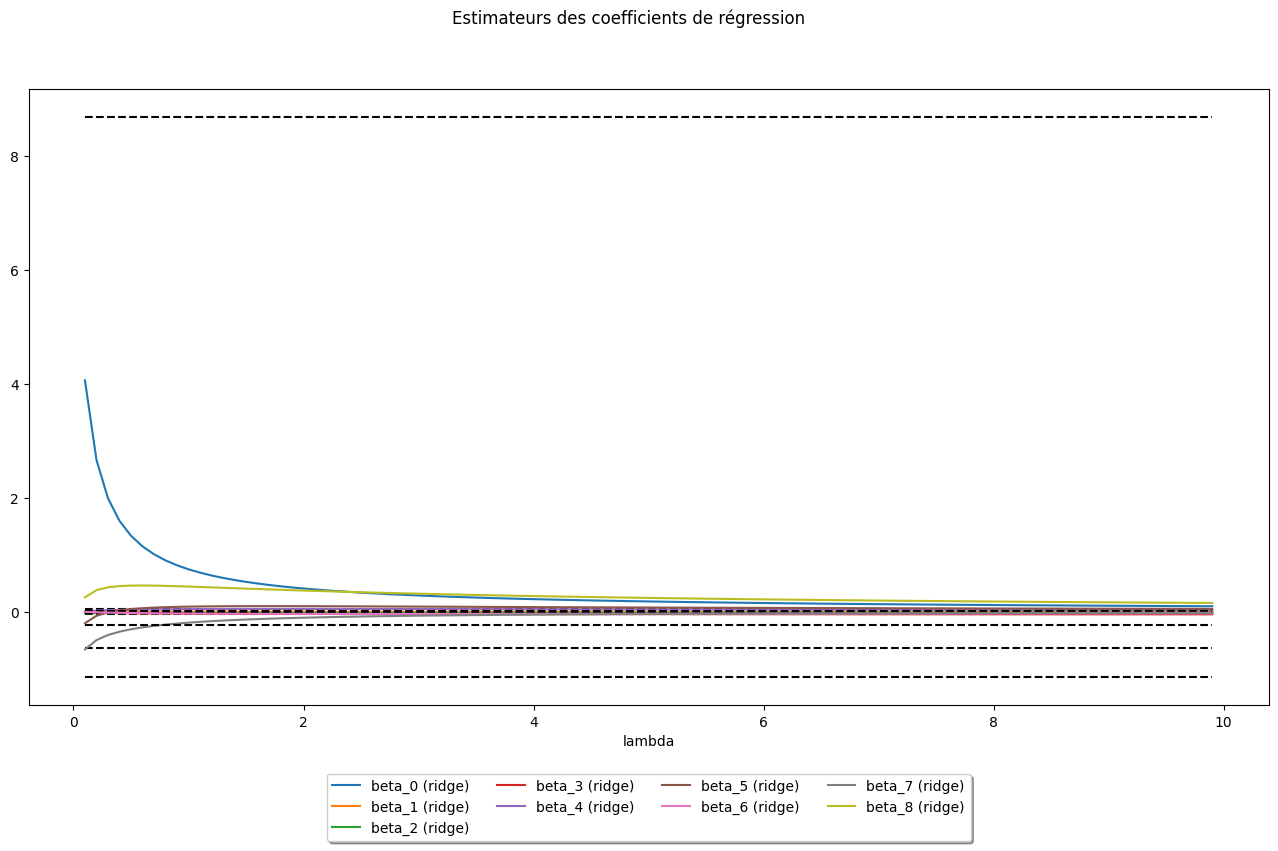

In [5]:
# Chargement des données
Xc, yc = caterpillar_data()

# Estimateur du maximum de vraisemblance
beta_mv = np.dot(np.dot(np.linalg.inv(np.dot(Xc.T, Xc)), Xc.T), yc)

# Estimateurs ridge pour différentes valeurs du paramètre
lambda_max = 10.0
lambdas = np.arange(0.1, lambda_max, 0.1)
beta_r = np.zeros((lambdas.shape[0], Xc.shape[1]))
for i in range(lambdas.shape[0]):
    beta_r[i, :] = np.dot(np.dot(np.linalg.inv(np.dot(Xc.T,Xc)+ lambdas[i]*np.identity(Xc.shape[1])), Xc.T), yc)             # TO DO calcul de l'estimateur Ridge

# Figure
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Estimateurs des coefficients de régression')
sp = plt.subplot(1, 1, 1)
sp.set_xlabel('lambda')
for j in range(Xc.shape[1]):
    _ = sp.plot(lambdas, np.full(lambdas.shape[0], beta_mv[j]), 'k--')
    _ = sp.plot(lambdas, beta_r[:, j], label="beta_{} (ridge)".format(j))
_ = sp.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=4)


<div class="alert alert-warning"><strong>REPONSE A LA QUESTION I.7.</strong><br>Les estimateurs ridge sont pénalisés beaucoup plus rapidement qu'à la question précédente. Cela peut en partie s'expliquer par le nombre de données plus faible (ici $n=33$).<br>On a aussi beaucoup de coefficients proches de 0 dès le départ, car les ordres de grandeurs des différentes variables dans les données ne sont pas proches. </div>

<h1>II. Variance connue</h1>

Nous considérons maintenant l'approche bayésienne pour le modèle linéaire gaussien ordinaire. Dans un premier temps, nous supposerons que la variance $\sigma^2$ du modèle est connue et nous nous intéresserons donc uniquement au vecteur $\beta \in \mathbb{R}^{p + 1}$ des coefficients de régression.


<p id="qii1" class="bg-primary" style="padding:1em"><strong>QUESTION II.1.</strong> En supposant que $X^\top X$ soit inversible, montrez que $X^\top (y - X \hat \beta_{\text{MV}}) = 0$ et déduisez-en que la vraisemblance $\ell(\beta \mid \mathbf{y}, X)$ à variance connue satisfait
\begin{equation*}
\ell(\beta \mid \mathbf{y}, X) \propto \exp\left( -\frac{1}{2\sigma^2} \lVert X (\beta - \hat{\beta}_{\text{MV}}) \rVert^2 \right).
\end{equation*}</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.1.</strong> <br>
    On a $\hat \beta_{\text{MV}} = (X^\top X )^{-1} X^\top y $ <br>
    Donc $X^\top ( y - X \hat \beta_{\text{MV}} ) = X^\top y  - X^\top X (X^\top X )^{-1} X^\top y $ <br>
    On en déduit donc $ X^\top ( y  - X \hat \beta_{\text{MV}}) =0 $ <br>
La vraisemblance vaut 
\begin{equation*}
\ell(\beta \mid \mathbf{y}, X) = \frac{1}{(2 \pi \sigma^2)^{\frac{n}{2}}}\exp\left( -\frac{1}{2\sigma^2} \lVert  (y - X\beta) \rVert^2 \right)   
\end{equation*}
Mais en écrivant : $\lVert  y - X\beta \rVert^2 = \lVert  y - \hat \beta_{\text{MV}} + X(\hat \beta_{\text{MV}} - \beta)   \rVert^2$ <br>
On obtient :
\begin{equation*}
    \lVert  y - X\beta \rVert^2 = \lVert  y - \hat \beta_{\text{MV}} \rVert^2 + 2 \langle X(\hat \beta_{\text{MV}} - \beta), y - \hat \beta_{\text{MV}} \rangle  + \lVert X(\hat \beta_{\text{MV}} - \beta) \rVert^2 
\end{equation*}
Le premier terme peut rentrer dans la constante et le dernier terme est celui que l'on cherche. Il ne reste plus que le terme du milieu que l'on peut faire disparaitre en observant : <br>
\begin{equation*}
\langle X(\hat \beta_{\text{MV}} - \beta), y - \hat \beta_{\text{MV}} \rangle 
    = \hat \beta^\top_{\text{MV}} X^\top( y - X  \hat \beta_{\text{MV}}) - \beta^\top X^\top( y - X \hat \beta_{\text{MV}}) = 0
\end{equation*}
On obtient la nullité du terme en utilisant le résultat prouvé au début de la question. Si on revient à l'expression précédente : 
    \begin{equation*}
    \lVert  y - X\beta \rVert^2 = \lVert  y - \hat \beta_{\text{MV}} \rVert^2   + \lVert X(\hat \beta_{\text{MV}} - \beta) \rVert^2 
\end{equation*}
On fait rentrer le premier terme dans la constante car indépendant de $\beta$ et on obtient donc que : <br>
    \begin{equation*}
\ell(\beta \mid \mathbf{y}, X) \propto \exp\left( -\frac{1}{2\sigma^2} \lVert X (\beta - \hat{\beta}_{\text{MV}}) \rVert^2 \right).
\end{equation*}
</div>

<h2>Lois conjuguées</h2>

La forme de la vraisemblance obtenue dans la question précédente nous invite à considérer une distribution a priori gaussienne pour le paramètre $\beta$,

\begin{equation*}
\beta \mid X \sim \mathcal{N}_{p+1}(\tilde \beta, \sigma^2 M^{-1})
\end{equation*}

où $\tilde \beta \in \mathbb{R}^{p+1}$ et $M$ est une matrice symétrique définie positive. Pour rappel, la densité de cette loi a priori est donnée par

\begin{equation*}
\forall \beta \in \mathbb{R}^{p+1},\ \pi(\beta \mid X) = \sqrt{\frac{\det(M)}{(2 \pi \sigma^2)^{p+1}}} \exp\left( -\frac{1}{2 \sigma^2}(\beta - \tilde \beta)^\top M (\beta - \tilde \beta) \right).
\end{equation*}



<p class="bg-primary" style="padding:1em"><strong>QUESTION II.2.</strong> En utilisant le DM, montrez que la loi a posteriori est une loi normale de moyenne $(X^\top X + M)^{-1}(X^\top X \hat \beta_{\text{MV}} + M \tilde \beta)$ et de variance $\sigma^2(X^\top X + M)^{-1}$ et donnez une interprétation de ce résultat. Quel est l'estimateur bayésien, que l'on notera $\hat \beta_{\text{B}, \tilde \beta, M}$, correspondant à une fonction de coût quadratique ?</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.2.</strong> En utilisant le résultat de la question III.2 du DM, en remplaçant respectivement $\beta_0$ par $\tilde \beta$ et $M_0$ par $M$ et en utilisant le fait que $ X^\top y   = X^\top X \hat \beta_{\text{MV}} $ ( d'après la question précédente) on obtient bien que la loi a posteriori est une loi normale de moyenne $(X^\top X + M)^{-1}(X^\top X \hat \beta_{\text{MV}} + M \tilde \beta)$ et de variance $\sigma^2(X^\top X + M)^{-1}$. <br>
Si on analyse le terme de variance, on voit que celui-ci prend à la fois en compte la variance que l'on a sur nos données ainsi que la variance que l'on a sur notre a priori ce qui est cohérent. De la même manière la moyenne est une sorte de combinaison entre l'estimateur du maximum de vraisemblance (déterminé grâce aux donnnées et observations) et la moyenne de la loi à priori. <br>
    
D'après le cours, l'estimateur bayésien correspondant à une fonction de coût quadratique est donné par la moyenne de la loi a posteriori <br>
    $\hat \beta_{\text{B}, \tilde \beta, M} = (X^\top X + M)^{-1}(X^\top X \hat \beta_{\text{MV}} + M \tilde \beta) $
</div>



<p class="bg-primary" style="padding:1em"><strong>QUESTION II.3.</strong> L'ensemble des lois gaussiennes non dégénérées dans $\mathbb{R}^{p+1}$ est-elle une famille conjuguée dans le cadre du modèle linéaire gaussien ordinaire à variance connue? Rappelez les avantages que présente une telle propriété.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.3.</strong> D'après le cours,l'ensemble des lois gaussiennes non dégénérées dans $\mathbb{R}^{p+1}$ est une famille conjuguée dans le cadre du modèle linéaire gaussien ordinaire à variance connue (exemple fil rouge section 3.3.2 à passer en dimension $p+1$). Un des avantages est que pour une famille exponentielle (comme notre cas) les familles conjuguées sont denses dans l'espace des distributions. On peut donc approcher n'importe quelle loi a priori par un mélange de lois conjuguées. </div>

<p id="bayes_ridge" class="bg-primary" style="padding:1em"><strong>QUESTION II.4.</strong> Pour quels choix de loi a priori les estimateurs Ridge et bayésien coïncident-ils ? Compte tenu de la question précédente, que dire de cet estimateur quand $\lambda$ tend vers $0$? Et quand $\lambda$ tend vers l'infini?</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.4.</strong><br> Pour rappel on a :
\begin{equation*}
\hat{\beta}_{\text{R}, \lambda} = (X^\top X + \lambda I_{p + 1})^{-1} X^\top \mathbf{y}.
\end{equation*}
et <br>
\begin{equation*}
\hat \beta_{\text{B}, \tilde \beta, M} = (X^\top X + M)^{-1}(X^\top X \hat \beta_{\text{MV}} + M \tilde \beta)
\end{equation*}
Si l'on prend $\tilde \beta =0 $ et $M = \lambda I_{p + 1}$ et en notant que $X^\top X \hat \beta_{\text{MV}} = X^\top \mathbf{y}$ comme démontré plus haut, les deux estimateurs coincident. Cela correspond à la loi normale a priori  
$\mathcal{N}_{p+1}(0 , \frac{\sigma^2}{\lambda} I_{p + 1})$. <br>
Lorsque $\lambda$ tend vers l'infini la loi tend a priori tend vers un dirac en zéro. Tandis que lorsque $\lambda$ tend vers $0$ on tend vers une loi uniforme sur $\mathbb{R}^{p+1}$ (loi impropre).
</div>

Le résultat de la question précédente est important car il illustre le fait que choisir une distribution a priori gaussienne centrée de matrice de covariance proportionnelle à l'identité dans un modèle linéaire gaussien ordinaire régularise naturellement la solution et stabilise l'estimateur du maximum de vraisemblance. En pratique, le choix $\tilde \beta = 0$ semble raisonnable en l'absence d'informations additionnelles mais celui de la matrice $M$ n'est pas aussi simple et essayer d'y intégrer de l'information sur les corrélations entre les coefficients $\beta_i$ s'avère souvent difficile. Il s'agit là d'une des raisons qui poussent généralement le statisticien à prendre $M$ de la forme $\lambda I_{p+1}$.

<p class="bg-primary" style="padding:1em"><strong>QUESTION II.5.</strong> Soit $\lambda > 0$, si $\tilde{\beta} = 0$ et $M = \lambda I_{p+1}$, déduisez des questions précédentes que, pour tout $i \in \{0, \dots, p\}$,<br/><br/>
\begin{equation*}
\beta_i \mid \mathbf{y}, X \sim \mathcal{N}(\hat{\beta}_{\text{R}, \lambda, i}, \sigma^2 \omega_{\lambda,i})
\end{equation*}
où $\omega_{\lambda,i} = (X^\top X + \lambda I_{p+1})^{-1}_{ii}$.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.5.</strong> <br> D'après la question II.2 : <br>
\begin{equation*}
\beta \mid \mathbf{y}, X \sim\mathcal{N}_{p+1}((X^\top X + M)^{-1}(X^\top y + M \tilde \beta), \sigma^2(X^\top X + M)^{-1})
\end{equation*}
Avec $\tilde{\beta} = 0$ et $M = \lambda I_{p+1}$ on a alors : <br>
\begin{equation*}
\beta \mid \mathbf{y}, X \sim\mathcal{N}_{p+1}((X^\top X + \lambda I_{p+1})^{-1} X^\top y, \sigma^2(X^\top X + \lambda I_{p+1})^{-1})
\end{equation*}
Ce que l'on peut réécrire en utilisant la définition de  $\hat{\beta}_{\text{R}, \lambda}$: <br>
\begin{equation*}
\beta \mid \mathbf{y}, X \sim\mathcal{N}_{p+1}(\hat{\beta}_{\text{R}, \lambda}, \sigma^2(X^\top X + \lambda I_{p+1})^{-1})
\end{equation*}
Puis pour chaque composante de $\beta_i$ on a: <br>
\begin{equation*}
\beta_i \mid \mathbf{y}, X \sim \mathcal{N}(\hat{\beta}_{\text{R}, \lambda, i}, \sigma^2 (X^\top X + \lambda I_{p+1})^{-1}_{ii})
\end{equation*}
Ce qui termine la démonstration du résultat !
</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION II.6.</strong> Soit $i \in \{0, \dots, p\}$, montrez que la région
<br/><br/>
\begin{equation*}
\left[ \hat{\beta}_{\text{R}, \lambda, i} - \phi^{-1}(1 - \alpha/2)\sqrt{\sigma^2 \omega_{\lambda,i}} , \hat{\beta}_{\text{R}, \lambda, i} + \phi^{-1}(1 - \alpha/2)\sqrt{\sigma^2 \omega_{\lambda,i}} \right]
\end{equation*}<br/>
où $\phi$ est la fonction de répartition d'une loi gaussienne standard dans $\mathbb{R}$, est un intervalle de crédibilité HPD de niveau $\alpha \in [0,1]$ pour le coefficient $\beta_i$.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.6.</strong> D'après la question précédente on remarque que $\pi(.| \mathbf{y}, X)$ est continue et n'admet qu'un seul maximum local. Dès lors la région HPD est un intervalle dont les bornes sont des quantiles de la loi a posteriori. D'après la question précédente on a pour tout $i$: <br>
\begin{equation*}
\beta_i \mid \mathbf{y}, X \sim \mathcal{N}(\hat{\beta}_{\text{R}, \lambda, i}, \sigma^2 \omega_{\lambda,i})
\end{equation*}
Donc pour tout $i$ :
\begin{equation*}   
 \frac{1}{\sqrt{\sigma^2 \omega_{\lambda,i}}}\left( \beta_i - \hat{\beta}_{\text{R}, \lambda, i} \right)  \sim \mathcal{N}(0, 1) \\ 
\mathbb{P}\left( -\phi^{-1}(1 - \alpha/2) \leq \frac{1}{\sqrt{\sigma^2 \omega_{\lambda,i}}}\left( \beta_i - \hat{\beta}_{\text{R}, \lambda, i} \right) \leq  \phi^{-1}(1 - \alpha/2) \right) = 1-\alpha \\
\mathbb{P}\left( \hat{\beta}_{\text{R}, \lambda, i} - \phi^{-1}(1 - \alpha/2) \sqrt{\sigma^2 \omega_{\lambda,i}} \leq \beta_i \leq  \hat{\beta}_{\text{R}, \lambda, i}  + \phi^{-1}(1 - \alpha/2) \sqrt{\sigma^2 \omega_{\lambda,i}} \right) = 1-\alpha
\end{equation*}
D' où le résultat
</div>

Pour appliquer ces résultats au jeu de données sur les chenilles processionnaires, nous remplaçons la variance $\sigma^2$ par la valeur estimée à la [question I.4](#qi4) mais il nous faut encore choisir une valeur $\lambda$.

<p id="qii7" class="bg-primary" style="padding:1em"><strong>QUESTION II.7.</strong> Complétez et exécutez le code suivant, puis répondez aux questions.<br/><br/>
    &#9679; Est-ce que le paramètre $\lambda$ a la même influence sur tous les coefficients?<br/>
    &#9679; Comment évoluent les intervalles de crédibilité quand $\lambda$ tend vers $0$? Et quand $\lambda$ augmente? Faites le lien avec la <a href="#bayes_ridge" style="color:white">question II.4</a>.<br/>
    &#9679; Est-ce que vos réponses à la question précédente vous semblent intuitives compte tenu du fait que $\lambda$ est le facteur de variance de la loi a priori?<br/>
    &#9679; Quel inconvénient y a-t-il à prendre $\lambda$ "grand" en pratique?<br/>
    &#9679; Utilisez les variables définies dans le code pour obtenir les intervalles de crédibilité sur les coefficients de régression pour $\lambda = 0.01$.</p>

Intervalles de confiance  des beta_i pour lambda = 0.01
Estimateur beta_0 -- [4.31,  11.3] -- 6.96
Estimateur beta_1 -- [-0.00439, -0.000414] -- 0.00398
Estimateur beta_2 -- [-0.0625, -0.0049] -- 0.0576
Estimateur beta_3 -- [-0.0149,  0.0836] -- 0.0985
Estimateur beta_4 -- [-0.396,  0.356] -- 0.752
Estimateur beta_5 -- [-1.66,  0.562] -- 2.22
Estimateur beta_6 -- [-0.272,  0.293] -- 0.564
Estimateur beta_7 -- [-2.07, -0.0335] -- 2.04
Estimateur beta_8 -- [-0.954,  0.691] -- 1.64


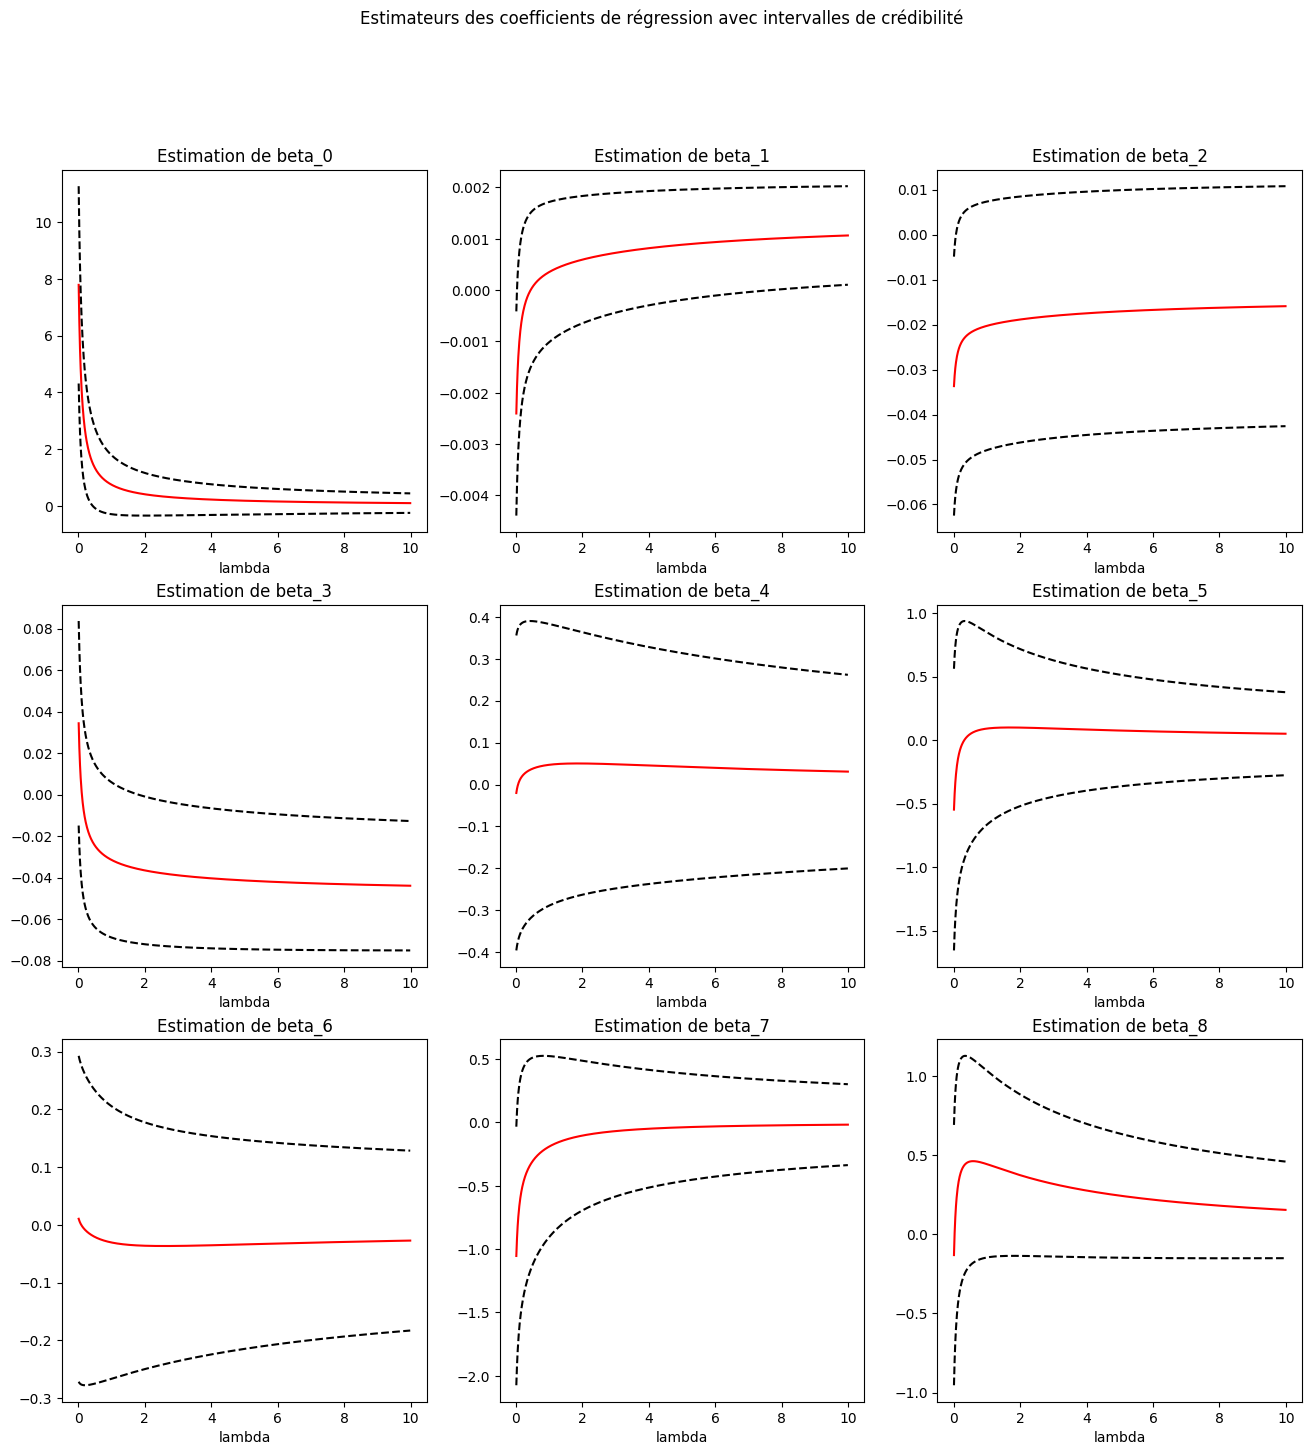

In [7]:
# Paramètres de la procédure
n, q = Xc.shape # q = p + 1
alpha = 0.05
lambda_max = 10.0
sigma2 = sigma2c_mv

# Éléments de l'estimation
lambdas = np.arange(0.01, lambda_max, 0.01)
beta_r = np.zeros((lambdas.shape[0], q))
phi = ss.norm.ppf(1.0 - alpha / 2.0)
borne = np.zeros((lambdas.shape[0], q))
for i in range(lambdas.shape[0]):
    # Q = inv(X.T X + lambda I)
    # Estimateur ridge
    Q = np.linalg.inv(np.dot(Xc.T, Xc) + lambdas[i] *np.identity(q))
    beta_r[i, :] =np.dot(np.dot(Q, Xc.T), yc)
    # Borne de l'intervalle de crédibilité
    omega = np.diag(Q)
    borne[i, :] = phi * np.sqrt(sigma2 * omega)

# Figures
print("Intervalles de confiance  des beta_i pour lambda = 0.01")
fig = plt.figure(figsize=(16, 16))
fig.suptitle('Estimateurs des coefficients de régression avec intervalles de crédibilité')
for j in range(q):
    sp = fig.add_subplot(3, 3, j+1)
    sp.set_title('Estimation de beta_{}'.format(j))
    sp.set_xlabel('lambda')
    sp.plot(lambdas, beta_r[:, j], 'r-',
            lambdas, beta_r[:, j] - borne[:, j], 'k--',
            lambdas, beta_r[:, j] + borne[:, j], 'k--')
    print(f"Estimateur beta_{j} -- [{beta_r[0, j] - borne[0, j]:.3}, {beta_r[0, j] + borne[0, j]: .3}] -- {2*borne[0, j]:.3}")

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.7.</strong> <br>
&#9679; Le paramètre $\lambda$ va plus impacter et vouloir annuler les coefficients ayant de fortes valeurs comme on peut le voir avec le coefficient $\beta_0$ et $\beta_7$.

&#9679; Quand $\lambda$ augmente les intervalles de confiance se resserrent tandis qu'avec un $\lambda$ petit les intervalles s'étendent. On peut faire le lien avec la question II.4, en effet on a évoqué le fait qu'avec un $\lambda$ élevé cela correspondait à un dirac donc une forte confiance dans notre a priori tandis qu'avec un $\lambda$ petit, on tendait vers une loi uniforme sur $\mathbb{R}^{p+1}$, donc presque pas d'information dans notre loi a priori. Il est donc logique que la taille de notre intervalle de confiance soit lié à l'information contenu dans notre loi a priori
    
&#9679; Oui cela parait intuitif comme évoqué à la ligne ci-dessus avoir une forte variance (faible $\lambda$) indique qu'on a peu de connaissance et l'intervalle de confiance sera grand. Au contraire, une faible variance ( grand $\lambda$) indique une bonne connaissance de la région du paramètre et donc logiquement un intervalle de confiance plus serré.
    
&#9679; En pratique prendre un $\lambda$ grand signifie que l'on va réduire beaucoup de coefficients $\beta_i$ à $0$ et trop simplifier le problème. 

&#9679; Les intervalles sont présentés juste avant les graphes

</div>

<h2>Prior non informatif</h2>

Dans la section précédente, nous avons prétendu que choisir une distribution a priori pour le vecteur $\beta$ qui soit gaussienne et centrée pouvait être raisonnable en l'absence d'informations additionnelles. Cependant, la statistique bayésienne permet de considérer cette absence d'information de manière plus naturelle à l'aide d'un prior impropre constant sur $\mathbb{R}^{p+1}$,
\begin{equation*}
\pi(\beta \mid X) = 1.
\end{equation*}

<p class="bg-primary" style="padding:1em"><strong>QUESTION II.8.</strong> Montrez que si $X^\top X$ est inversible, alors la distribution a posteriori de $\beta \mid \mathbf{y}, X$ est donnée par<br/><br/>
\begin{equation*}
\mathcal{N}_{p+1}\left( \hat{\beta}_{\text{MV}}, \sigma^2(X^\top X)^{-1} \right).
\end{equation*}<br/>
Expliquez le problème qui se pose pour définir la distribution a posteriori si $X^\top X$ n'est pas inversible.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.8.</strong> Une façon avec les mains de montrer ce résultat serait de partir des questions précédentes et de faire tendre $\lambda$ vers zéro. Pour le prouver plus justement , on utilise la loi de Bayes :
\begin{equation*}
\pi(\beta \mid \mathbf{y} , X) \propto \pi(\beta \mid X) \times f(\mathbf{y} \mid \beta, X) 
\end{equation*}
On remarque donc que $\pi(\beta \mid \mathbf{y} , X)$ est proportionnel à la vraisemblance et en utilisant la réponse à la 
question II.2, comme $X^\top X$ est considérée inversible on a bien <br>
\begin{equation*}
\pi(\beta \mid \mathbf{y} , X) \sim \mathcal{N}_{p+1}\left( \hat{\beta}_{\text{MV}}, \sigma^2(X^\top X)^{-1} \right)
\end{equation*}
Si la matrice $X^\top X$ n'est pas inversible l'estimateur du maximum de vraisemblance n'est pas défini $\hat{\beta}_{\text{MV}}$ car pour le construire nous avions supposé $X^\top X$ inversible.
</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION II.9.</strong> On fixe $i \in \{0, \dots, p\}$. Montrez que si $X^\top X$ est inversible, alors la région
<br/><br/>
\begin{equation*}
\left[ \hat{\beta}_{\text{MV}, i} - \phi^{-1}(1 - \alpha/2)\sqrt{\sigma^2 \omega_{0,i}} , \hat{\beta}_{\text{MV}, i} + \phi^{-1}(1 - \alpha/2)\sqrt{\sigma^2 \omega_{0,i}} \right]
\end{equation*}<br/>
où $\omega_{0,i} = (X^\top X)^{-1}_{ii}$ est un intervalle de crédibilité HPD de niveau $\alpha \in [0,1]$ pour le coefficient $\beta_i$.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.9.</strong>De la même manière que la question II.5. et en utilisant la question II.8, on a pour tout $i$ (en considérant $X^\top X$ inversible) : <br>
\begin{equation*}    
    \beta_i \mid \mathbf{y}, X \sim \mathcal{N}(\hat{\beta}_{\text{MV}, i} , \sigma^2(X^\top X)^{-1}_{ii})
\end{equation*}
Puis en effectuant exactement le même raisonnement qu'à la question II.6 on a directement : <br>
\begin{equation*}   
\mathbb{P}\left( \hat{\beta}_{\text{MV}, i}  - \phi^{-1}(1 - \alpha/2) \sqrt{\sigma^2 \omega_{0,i}} \leq \beta_i \leq   \hat{\beta}_{\text{MV}, i}  \phi^{-1}(1 - \alpha/2) \sqrt{\sigma^2 \omega_{0, i}} \right) = 1-\alpha
\end{equation*}
Donc on a bien l'intervalle de confiance demandé avec le niveau de confiance considéré !
    
</div>

Il convient ici de remarquer que les intervalles de crédibilité que nous obtenons par l'approche bayésienne avec ce prior non informatif coïncident avec ceux obtenus dans un modèle de régression linéaire gaussien par l'approche fréquentiste.

<p class="bg-primary" style="padding:1em"><strong>QUESTION II.10.</strong> Complétez et exécutez le code suivant, puis comparez les résultats obtenus avec ceux de la <a href="#qii7" style="color:white">question II.7</a>.</p>

In [8]:
# Intervalles de crédibilité
omega_0 = np.diag(np.linalg.inv(np.dot(Xc.T, Xc)))
borne = phi * np.sqrt(sigma2 * omega_0)
for i in range(betac_mv.shape[0]):
    print("beta_{} : [{:.3}, {:.3}] - {:.3}".format(i, betac_mv[i] - borne[i], betac_mv[i] + borne[i], 2*borne[i]))

beta_0 : [5.01, 12.4] - 7.35
beta_1 : [-0.00478, -0.000696] - 0.00408
beta_2 : [-0.0641, -0.00639] - 0.0577
beta_3 : [-0.00813, 0.0926] - 0.101
beta_4 : [-0.403, 0.35] - 0.753
beta_5 : [-1.75, 0.489] - 2.24
beta_6 : [-0.27, 0.296] - 0.566
beta_7 : [-2.18, -0.114] - 2.06
beta_8 : [-1.06, 0.608] - 1.67


<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.10.</strong>On remarque que les intervalles de confiance sont plus grands que ceux vus en question II.7. Cela parait logique car notre loi a priori est non informative alors qu'en question II.7 on considérait une loi gaussienne ce qui montre déjà une certaine connaissance sur les coefficients $\beta_i$. Ainsi une loi non informative conduit à des intervalles de confiances plus grands mais cela reste cependant comparable aux résultats de la question II.7</div>

Pour terminer cette étude du cas à variance connue, nous discutons de l'impact du nombre d'observations $n$ sur les procédures d'estimation présentées ci-dessus. Afin de faire varier ce paramètre, nous générons un jeu de données simulées dont nous ne considérons que les $10$ premières observations, puis les $20$ premières observations, $\dots$ de façon à visualiser l'évolution des estimateurs des coefficients de régression et des intervalles de crédibilité associés quand $n$ grandit. Nous définissons également une fonction `xgen` pour générer les variables explicatives de telle sorte que les deux dernières soient proches d'être colinéaires afin d'en discuter les conséquences.

<p id="qii12" class="bg-primary" style="padding:1em"><strong>QUESTION II.11.</strong> Complétez et exécutez le code suivant, puis répondez aux questions.<br/><br/>
    &#9679; Comparez les deux méthodes lorsque $n$ devient grand.<br/>
    &#9679; Décrivez et expliquez les différences de comportement des estimateurs et des intervalles de crédibilité entre ceux relatifs aux deux premiers coefficients $\beta_0$ et $\beta_1$ et ceux relatifs aux deux derniers coefficients $\beta_2$ et $\beta_3$.<br/>
    &#9679; Pour des petites valeurs de $n$, quel choix de distribution a priori sur $\beta$ semble le plus judicieux compte tenu de ces simulations?</p>

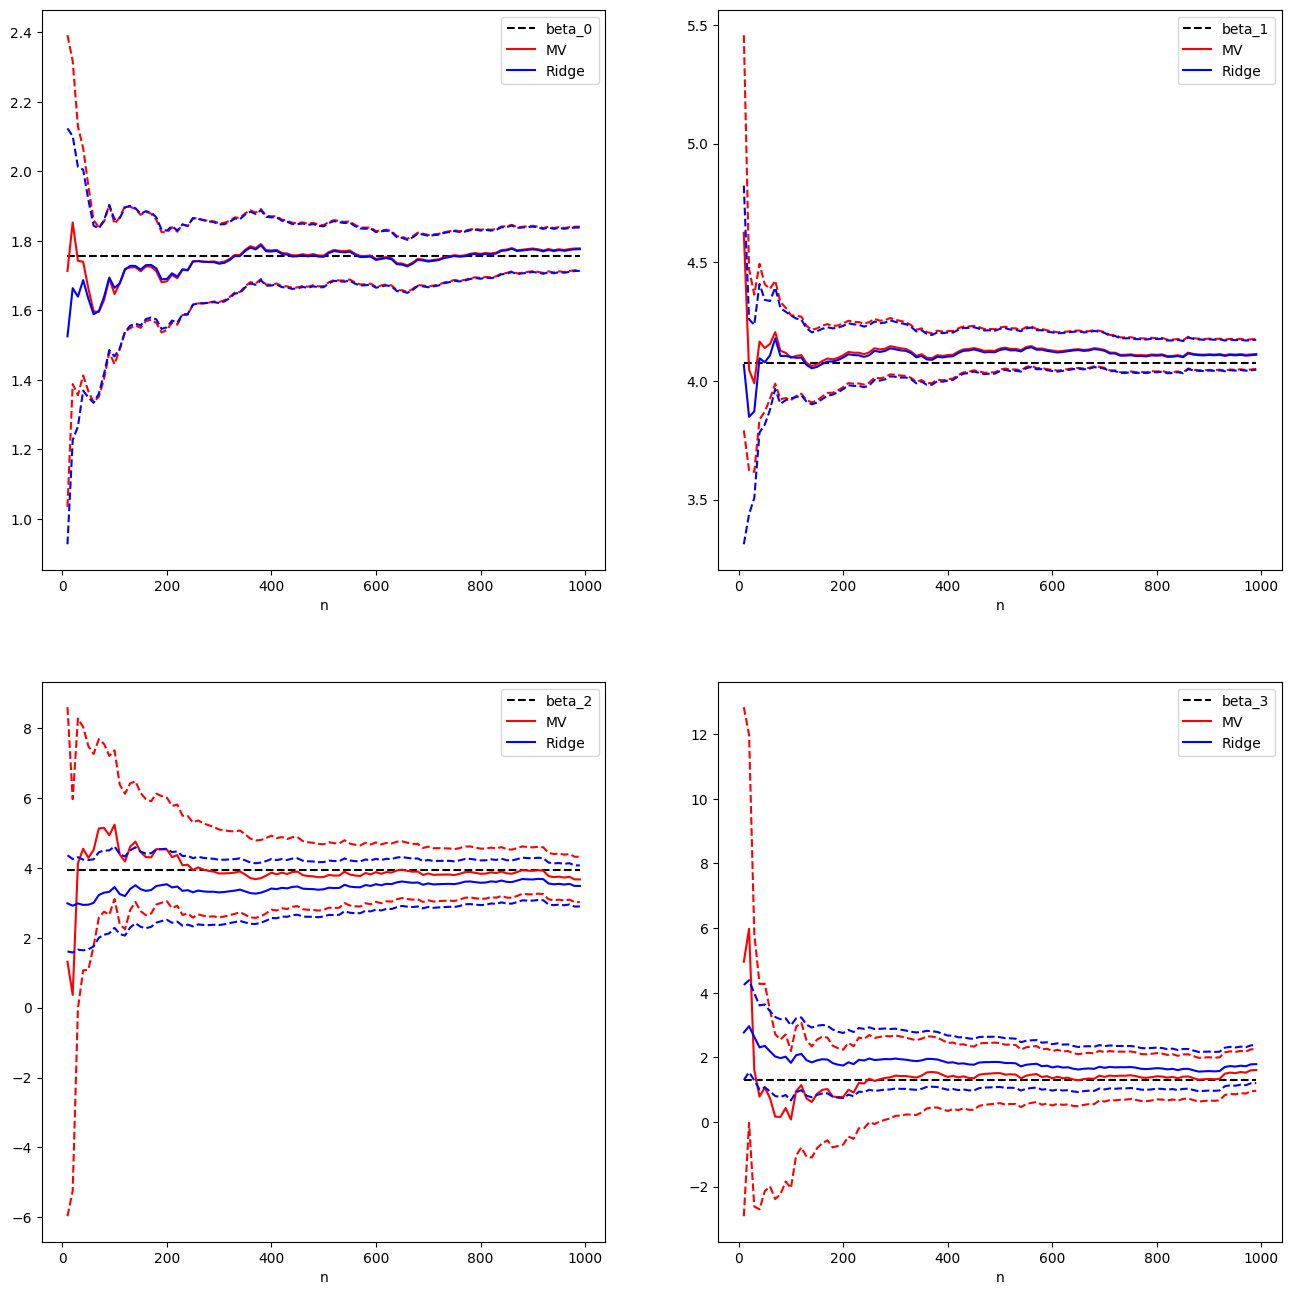

In [10]:
# Paramètres de la simulation
n, p = 1000, 3
beta = np.random.uniform(-5.0, 5.0, p + 1)
sigma2 = 1.0

# Fonction de génération des variables explicatives
def xgen(p):
    z = np.random.normal(size=p)
    z[-1] = z[-2] + z[-1] / 10.0
    return z

# Génération des données
Xs, ys = simu_data(n, beta, sigma2, xgen)

# Paramètres de l'étude
lbd = 1.0
alpha = 0.05
phi = ss.norm.ppf(1.0 - (alpha/2.0)) # TO DO quel(s) paramètre(s) passer à la fonction ppf ?

# Calculs des estimateurs et des intervalles de crédibilité
n_grille = np.arange(10, n, 10)
nn = n_grille.shape[0]
beta_mv = np.zeros((nn, p+1))
borne_mv = np.zeros((nn, p+1))
beta_r = np.zeros((nn, p+1))
borne_r = np.zeros((nn, p+1))
for i in range(nn):
    # Données tronquées
    Xn = Xs[:n_grille[i], :]
    yn = ys[:n_grille[i]]
    # Estimateur du maximum de vraisemblance
    # Q_0 = inv(Xn.T Xn)
    Q_0 = np.linalg.inv(np.dot(Xn.T, Xn))
    beta_mv[i, :] = np.dot(np.dot(Q_0, Xn.T), yn)   # TO DO calcul de l'estimateur du maximum de vraisemblance
    omega_0 = np.diag(Q_0)  # TO DO calcul de omega_0
    borne_mv[i, :] = phi * np.sqrt(sigma2 * omega_0)
    # Estimateur ridge
    # Q = inv(Xn.T Xn + lbda I_p+1)
    Q = np.linalg.inv(np.dot(Xn.T, Xn) + lbd *np.identity(p+1))
    beta_r[i, :] = np.dot(np.dot(Q, Xn.T), yn) # TO DO calcul de l'estimateur Ridge
    omega = np.diag(Q)# TO DO calcul de omega
    borne_r[i, :] = phi * np.sqrt(sigma2 * omega)

# Figures
fig = plt.figure(figsize=(16, 16))
for j in range(p + 1):
    sp = fig.add_subplot(2, 2, j+1)
    sp.set_xlabel('n')
    sp.plot(n_grille, np.full(nn, beta[j]), 'k--', label='beta_{}'.format(j))
    sp.plot(n_grille, beta_mv[:, j], 'r-', label='MV')
    sp.plot(n_grille, beta_mv[:, j] - borne_mv[:, j], 'r--')
    sp.plot(n_grille, beta_mv[:, j] + borne_mv[:, j], 'r--')
    sp.plot(n_grille, beta_r[:, j], 'b-', label='Ridge')
    sp.plot(n_grille, beta_r[:, j] - borne_r[:, j], 'b--')
    sp.plot(n_grille, beta_r[:, j] + borne_r[:, j], 'b--')
    sp.legend()

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION II.11.</strong> <br>
&#9679; Lorsque $n$ devient grand, les deux méthodes tendent l'une vers l'autre. On peut remarquer cela particulièrement sur les deux premiers coefficients $\beta_0$ et $\beta_1$. Cependant pour $\beta_2$ et $\beta_3$ il reste un certain décalage même lorsque $n$ est grand<br/>
    &#9679; Les deux premiers coefficients $\beta_0$ et $\beta_1$ se comportent de la même manière pour les deux méthodes lorsque $n$ augmente. On voit même que l'estimateur du maximum de vraisemblance et l'estimateur de ridge coincident ainsi que leur intervalles de confiance. Pour les coefficients $\beta_2$ et $\beta_3$ le comportement est différent, en effet on voit qu'il faut même $n$ très grand pour que les  deux estimateurs ainsi que leurs intervalles de confiance coincident.Pour $n$ petit la différence est plus marqué car les termes extradiagonaux dû à la corrélation entre ces deux variables impactent beaucoup l'estimateur de ridge ainsi que le $\lambda$. Par ailleurs on peut remarquer facilement que les intervalles de confiance sont bien plus étroits à $n$ petit avec l'estimateur de ridge qu'avec l'estimateur du maximum du vraisemblance. <br/>
&#9679; <br/>
</div>

<h1>III. Variance inconnue (Partie optionnelle)</h1>

Dans la partie précédente nous avons supposé que la variance $\sigma^2$ du modèle linéaire gaussien ordinaire était connue. En pratique, une telle hypothèse est souvent impossible à satisfaire et il est nécessaire d'intégrer l'estimation de $\sigma^2$ à la procédure statistique. Pour cela, l'approche bayésienne nous permet de considérer une distribution jointe a priori pour le couple $(\beta, \sigma^2)$.

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.1.</strong> Expliquez pourquoi remplacer $\sigma^2$ par un estimateur de la variance comme nous l'avons fait dans la <a href="#qii7" style="color:white">question II.7</a> n'est pas satisfaisant.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.1.</strong> Ecrivez votre réponse ICI.</div>

Les calculs pour obtenir les distributions a posteriori considérées dans la suite sont fastidieux et nous les omettrons pour la plupart. En dehors de la question suivante, plusieurs résultats seront admis et donnés dans l'énoncé. Ces calculs sont cependant faisables et représentent de bons exercices nécessitant rigueur et patience que nous vous invitons à faire lors de la rédaction de votre rapport mais qui sont **optionnels**.

La loi inverse-gamma $\mathcal{IG}(a,b)$ de paramètres $a, b > 0$ joue un rôle important dans les sections suivantes. Pour rappel, cette loi est à support dans $\mathbb{R}^*_+$ et sa densité par rapport à la mesure de Lebesgue est donnée par

\begin{equation*}
\forall s > 0,\ f_{a,b}(s) = \frac{b^a e^{-b / s}}{\Gamma(a) s^{a+1}}
\end{equation*}

où $\Gamma(a) = \int_0^{+\infty} t^{a-1} e^{-t} dt$. De plus, si $S \sim \mathcal{IG}(a,b)$ avec $a > 1$ et $b > 0$, alors $\mathbb{E}[S] = b / (a - 1)$.

Le résultat technique suivant illustre le lien entre la loi gaussienne et la loi inverse-gamma et sera utile pour déterminer la distribution a posteriori des coefficients de régression.

<p id="qtech" class="bg-primary" style="padding:1em"><strong>QUESTION III.2.</strong> Soient $S$ et $T$ deux variables aléatoires réelles telles que $S \sim \mathcal{IG}(a,b)$ avec $a, b > 0$ et la loi conditionnelle de T est donnée par
\begin{equation*}
T \mid S \sim \mathcal{N}\left( 0, \frac{a S}{b} \right).
\end{equation*}<br/>
En intégrant la loi de $T \mid S$ par rapport à celle de $S$, montrer que
\begin{equation*}
T \sim \mathcal{T}(2a)
\end{equation*}
où $\mathcal{T}(\nu)$ désigne la loi de Student à $\nu > 0$ degrés de liberté.<br/><br/>
<b>Rappel :</b> la densité de la loi $\mathcal{T}(\nu)$ par rapport à la mesure de Lebesgue est donnée par<br/><br/>
\begin{equation*}
\forall t \in \mathbb{R},\ f_{\nu}(t) = \frac{\Gamma\left( \frac{\nu + 1}{2} \right)}{\Gamma\left( \frac{\nu}{2} \right)\sqrt{\nu\pi}} \left( 1 + \frac{t^2}{\nu} \right)^{-(\nu + 1) /2}.
\end{equation*}</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.2.</strong> Ecrivez votre réponse ICI.</div>

<h2>Lois conjuguées</h2>

Comme dans la partie précédente, nous pouvons nous laisser guider par la forme de la vraisemblance du modèle linéaire gaussien ordinaire et considérer la loi conditionnelle a priori sur $\beta \in \mathbb{R}^{p+1}$,

\begin{equation*}
\beta \mid X, \sigma^2 \sim \mathcal{N}_{p+1}(\tilde{\beta}, \sigma^2M^{-1})
\end{equation*}

où $\tilde{\beta} \in \mathbb{R}^{p+1}$ et $M$ est une matrice symétrique définie positive, ainsi que la loi a priori sur $\sigma^2 > 0$,

\begin{equation*}
\sigma^2 \mid X \sim \mathcal{IG}(a,b)
\end{equation*}

où $\mathcal{IG}(a,b)$ désigne la loi inverse-gamma de paramètres $a, b > 0$. Il faut remarquer ici que la loi a priori du couple $(\beta, \sigma^2)$ n'est pas donnée de façon explicite mais uniquement au travers de ses marginales.

Ces choix nous conduisent à la loi conditionnelle a posteriori de $\beta \mid \mathbf{y}, X, \sigma^2$,

\begin{equation*}
\beta \mid \mathbf{y}, X, \sigma^2 \sim \mathcal{N}_{p+1}\left( (X^\top X + M)^{-1}(X^\top \mathbf{y} + M \tilde{\beta}), \sigma^2(X^\top X + M)^{-1} \right)
\end{equation*}<br/>

et à la loi a posteriori de $\sigma^2 \mid \mathbf{y}, X$,

\begin{equation*}
\sigma^2 \mid \mathbf{y}, X \sim \mathcal{IG}\left( \frac{n}{2} + a, b + \frac{s^2}{2} + \frac{(\tilde{\beta} - \hat{\beta}_{MV})^\top \left( (X^\top X)^{-1} + M^{-1} \right)^{-1} (\tilde{\beta} - \hat{\beta}_{MV})}{2} \right).
\end{equation*}

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.3.</strong> Déduisez de ces résultats que l'ensemble des distributions jointes formées par une loi gaussienne non dégénérée pour la moyenne conditionnelle et d'une inverse-gamma pour la variance est une famille conjuguée dans le cadre du modèle linéaire gaussien ordinaire.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.3.</strong> Ecrivez votre réponse ICI.</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.4.</strong> Montrez que nous retrouvons le même estimateur bayésien $\hat{\beta}_1 = \hat{\beta}_{\text{B}, \tilde{\beta}, M}$ de $\beta$ pour la fonction de perte des moindres carrés que dans le cas à variance connue. Si $n \geqslant 2$, montrez également que l'estimateur bayésien de la variance associé à la fonction de perte des moindres carrés est donné par<br/><br/>
\begin{equation*}
\hat{\sigma}_1^2 = \frac{2b + s^2 + (\tilde{\beta} - \hat{\beta}_{\text{MV}})^\top \left( (X^\top X)^{-1} + M^{-1} \right)^{-1} (\tilde{\beta} - \hat{\beta}_{\text{MV}})}{n + 2a - 2}.
\end{equation*}</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.4.</strong> Ecrivez votre réponse ICI.</div>

<p id="qiii5"class="bg-primary" style="padding:1em"><strong>QUESTION III.5.</strong> Soit $i \in \{0, \dots, p\}$, montrez que
\begin{equation*}
\frac{\beta_i - \hat{\beta}_{1,i}}{\sqrt{\omega_{1,i}}} \mid \mathbf{y}, X, \sigma^2 \sim \mathcal{N}(0, \sigma^2)
\end{equation*}
où $\omega_{1,i} = (X^\top X + M)^{-1}_{ii}$. Déduisez-en que<br/><br/>
\begin{equation*}
\frac{\sqrt{\kappa_1}(\beta_i - \hat{\beta}_{1,i})}{\sqrt{\omega_{1,i}}} \mid \mathbf{y}, X \sim \mathcal{T}(n + 2a) \ \text{ où } \ \kappa_1 = \frac{n+2a}{2b + s^2 + (\tilde{\beta} - \hat{\beta}_{\text{MV}})^\top \left( (X^\top X)^{-1} + M^{-1} \right)^{-1} (\tilde{\beta} - \hat{\beta}_{\text{MV}})}
\end{equation*}.</p>


<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.5.</strong> Ecrivez votre réponse ICI.</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.6.</strong> Soit $i \in \{0, \dots, p\}$, montrez que
<br><br>
\begin{equation*}
\left[ \hat{\beta}_{1, i} - \psi_{n + 2a}^{-1}(1 - \alpha/2)\sqrt{\frac{\omega_{1,i}}{\kappa_1}} , \hat{\beta}_{1, i} + \psi_{n + 2a}^{-1}(1 - \alpha/2)\sqrt{\frac{\omega_{1,i}}{\kappa_1}} \right]
\end{equation*}<br/>
où $\psi_{n + 2a}$ est la fonction de répartition d'une loi de Student à $n + 2a$ degrés de liberté est un intervalle de crédibilité HPD de niveau $\alpha \in [0,1]$ pour le coefficient $\beta_i$.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.6.</strong> Ecrivez votre réponse ICI.</div>

En pratique, pour utiliser cette procédure d'estimation, il faut choisir la valeur des paramètres $\tilde{\beta}$, $M$, $a$ et $b$. Les mêmes arguments que dans la partie précédente conduisent souvent le statisticien à prendre $\tilde{\beta} = 0$ et $M = \lambda I_{p+1}$ pour un certain $\lambda > 0$. Par contre, le choix de $a$ et de $b$
est plus complexe et cette discussion dépasse le cadre du BE.

<h2>G-prior de Zellner</h2>

L'idée du G-prior de Zellner est de permettre au statisticien d'introduire de l'information sur les coefficients de régression tout en évitant une structure de corrélation complexe entre les distributions a priori de $\beta$ et de $\sigma^2$. Cette proposition de Zellner correspond à

\begin{equation*}
\beta \mid X, \sigma^2 \sim \mathcal{N}_{p+1} \left( \tilde{\beta}, \sigma^2 \lambda^{-1} (X^\top X)^{-1} \right) \quad \text{et} \quad \pi \left( \sigma^2 \mid X \right) = \sigma^{-2}
\end{equation*}

où $\tilde{\beta} \in \mathbb{R}^{p+1}$ et $\lambda > 0$.

Ce choix est un premier pas vers un prior non informatif et consiste donc à prendre un a priori conditionnel gaussien sur $\beta$ et un prior impropre pour $\sigma^2$. Comme dans la section précédente, la loi a priori du couple $(\beta, \sigma^2)$ n'est pas donnée de façon explicite mais uniquement au travers de ses marginales. La simplicité de ce modèle provient du fait qu'il n'y a plus que les deux valeurs de $\tilde{\beta}$ et $\lambda$ à choisir au lieu des quatre valeurs de $\tilde{\beta}$, $M$, $a$ et $b$ dans la section précédente.

Des calculs rigoureux mènent à la loi conditionnelle a posteriori de $\beta \mid \mathbf{y}, X, \sigma^2$,

\begin{equation*}
\beta \mid \mathbf{y}, X, \sigma^2 \sim \mathcal{N}_{p+1}\left( \frac{1}{1 + \lambda} \left( \hat{\beta}_{\text{MV}} + \lambda \tilde{\beta} \right), \frac{\sigma^2}{1 + \lambda} (X^\top X)^{-1} \right)
\end{equation*}<br/>

et à la loi a posteriori de $\sigma^2 \mid \mathbf{y}, X$,

\begin{equation*}
\sigma^2 \mid \mathbf{y}, X \sim \mathcal{IG}\left( \frac{n}{2}, \frac{s^2}{2} + \frac{\lambda}{2(1 + \lambda)}(\tilde{\beta} - \hat{\beta}_{\text{MV}})^\top X^\top X (\tilde{\beta} - \hat{\beta}_{\text{MV}}) \right).
\end{equation*}

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.7.</strong> En considérant la fonction de perte des moindres carrés, donnez l'estimateur $\hat{\beta}_2$ de $\beta$ que nous obtenons et montrez que, si $n > 2$, alors l'estimateur bayésien de la variance vaut<br/><br/>
\begin{equation*}
\hat{\sigma}_2^2 = \frac{(1 + \lambda)s^2 + \lambda (\tilde{\beta} - \hat{\beta}_{\text{MV}})^\top X^\top X (\tilde{\beta} - \hat{\beta}_{\text{MV}})}{(1 + \lambda) (n - 2)}.
\end{equation*}</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.7.</strong> Ecrivez votre réponse ICI.</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.8.</strong> Interprétez le rôle du paramètre $\lambda$ dans cette procédure. Décrivez le comportement des estimateurs $\hat{\beta}_2$ et $\hat{\sigma}_2^2$ quand $\lambda$ tend vers $0$ et vers l'infini.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.8.</strong> Ecrivez votre réponse ICI.</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.9.</strong> Soit $i \in \{0, \dots, p\}$, de la même façon que dans la <a href="#qiii5" style="color:white">question III.5</a>, montrez que<br/><br/>
\begin{equation*}
\frac{\sqrt{\kappa_2}(\beta_i - \hat{\beta}_{2,i})}{\sqrt{\omega_{2,i}}} \mid \mathbf{y}, X \sim \mathcal{T}(n)
\end{equation*}<br/>
où $\omega_{2,i} = \dfrac{1}{1 + \lambda} (X^\top X)^{-1}_{ii}$ et
\begin{equation*}
\kappa_2 = \frac{(1 + \lambda) n}{(1 + \lambda)s^2 + \lambda (\tilde{\beta} - \hat{\beta}_{\text{MV}})^\top X^\top X (\tilde{\beta} - \hat{\beta}_{\text{MV}})}.
\end{equation*}
</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.9.</strong> Ecrivez votre réponse ICI.</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.10.</strong> Soit $i \in \{0, \dots, p\}$, déduisez que
<br><br>
\begin{equation*}
\left[ \hat{\beta}_{2, i} - \psi_n^{-1}(1 - \alpha/2)\sqrt{\frac{\omega_{2,i}}{\kappa_2}} , \hat{\beta}_{2, i} + \psi_n^{-1}(1 - \alpha/2)\sqrt{\frac{\omega_{2,i}}{\kappa_2}} \right]
\end{equation*}<br/>
où $\psi_n$ est la fonction de répartition d'une loi de Student à $n$ degrés de liberté est un intervalle de crédibilité HPD de niveau $\alpha \in [0,1]$ pour le coefficient $\beta_i$.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.10.</strong> Ecrivez votre réponse ICI.</div>

En pratique, si aucun renseignement sur les coefficients de régression n'est connu, il est courant de considérer $\tilde{\beta} = 0$. Comme dans le cas à variance connue, ce choix ne correspond pas réellement à une absence d'information pour laquelle il faut considérer un prior non informatif.

<h2>Prior non informatif</h2>

Le dernier choix d'a priori sur le couple $(\beta, \sigma^2)$ que nous considérerons est connu comme le prior de Jeffreys et consiste à prendre la distribution a priori impropre

\begin{equation*}
\pi(\beta, \sigma^2 \mid X) = \sigma^{-2}.
\end{equation*}

Dans ce cas, nous n'apportons plus d'information et nous obtenons la loi conditionnelle a posteriori de $\beta \mid \mathbf{y}, X, \sigma^2$,

\begin{equation*}
\beta \mid \mathbf{y}, X, \sigma^2 \sim \mathcal{N}_{p+1}(\hat{\beta}_{\text{MV}}, \sigma^2(X^\top X)^{-1})
\end{equation*}

et à la loi a posteriori de $\sigma^2 \mid \mathbf{y}, X$,

\begin{equation*}
\sigma^2 \mid \mathbf{y}, X \sim \mathcal{IG}\left( \frac{n - p - 1}{2}, \frac{s^2}{2} \right).
\end{equation*}

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.11.</strong> En considérant la fonction de perte des moindres carrés, si $n > p + 3$, montrez que le couple d'estimateur bayésiens $(\hat{\beta}_3, \hat{\sigma}_3^2)$ de $(\beta, \sigma^2)$ que nous obtenons est celui donné par l'estimateur du maximum de vraisemblance $\hat{\beta}_{\text{MV}}$ de $\beta$ et par<br/><br/>
\begin{equation*}
\hat{\sigma}_3^2 = \frac{s^2}{n - p - 3}.
\end{equation*}</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.11.</strong> Ecrivez votre réponse ICI.</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.12.</strong> Soit $i \in \{0, \dots, p\}$, de la même façon que dans la <a href="#qiii5" style="color:white">question III.5</a>, montrez que<br/><br/>
\begin{equation*}
\frac{(\beta_i - \hat{\beta}_{3,i})}{\sqrt{\omega_{3,i}\hat{\sigma}_{\text{MV}}^2}} \mid \mathbf{y}, X \sim \mathcal{T}(n - p - 1)
\end{equation*}<br/>
où $\omega_{3,i} = (X^\top X)^{-1}_{ii}$.
</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.12.</strong> Ecrivez votre réponse ICI.</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION III.13.</strong> Soit $i \in \{0, \dots, p\}$, déduisez que
<br><br>
\begin{equation*}
\left[ \hat{\beta}_{3, i} - \psi_{n - p - 1}^{-1}(1 - \alpha/2)\sqrt{\omega_{3,i}\hat{\sigma}_{\text{MV}}^2} , \hat{\beta}_{3, i} + \psi_{n - p - 1}^{-1}(1 - \alpha/2)\sqrt{\omega_{3,i}\hat{\sigma}_{\text{MV}}^2} \right]
\end{equation*}<br/>
où $\psi_{n - p - 1}$ est la fonction de répartition d'une loi de Student à $n - p - 1$ degrés de liberté est un intervalle de crédibilité HPD de niveau $\alpha \in [0,1]$ pour le coefficient $\beta_i$.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION III.13.</strong> Ecrivez votre réponse ICI.</div>

<h1>IV. Simulations</h1>

Afin d'illustrer ces diverses procédures d'estimation, nous considérons maintenant quelques simulations dans le même cadre que la [question II.12](#qii12). Le premier code permet de comparer les différents estimateurs de la variance et le second se concentre sur les intervalles de crédibilité pour les coefficients de régression. Les paramètres utilisés par défaut sont $a = 2.1$, $b = 2$, $\tilde{\beta} = 0$, $M = \lambda I_{p+1}$ et $\lambda = 0.01$.

<p class="bg-primary" style="padding:1em"><strong>QUESTION IV.1.</strong> Complétez et exécutez le code suivant, puis répondez aux questions.<br/><br/>
    &#9679; Faites varier la valeur de $\lambda$ et interprétez le rôle de ce paramètre pour $\hat{\sigma}_1^2$ et $\hat{\sigma}_2^2$.<br/>
    &#9679; Faites varier les valeurs de $a$ et $b$ et interprétez le rôle de ces paramètres pour $\hat{\sigma}_1^2$.<br/>
    &#9679; Commentez le comportement de l'estimateur $\hat{\sigma}_2^2$ obtenu avec le G-prior de Zellner.<br/>
    &#9679; Expliquez les différences entre $\hat{\sigma}_{\text{MV}}^2$, $\hat{\sigma}_1^2$ et $\hat{\sigma}_3^2$.<br/>
    &#9679; Est-il important d'avoir une "bonne" estimation de $\sigma^2$ pour estimer les coefficients de régression?</p>

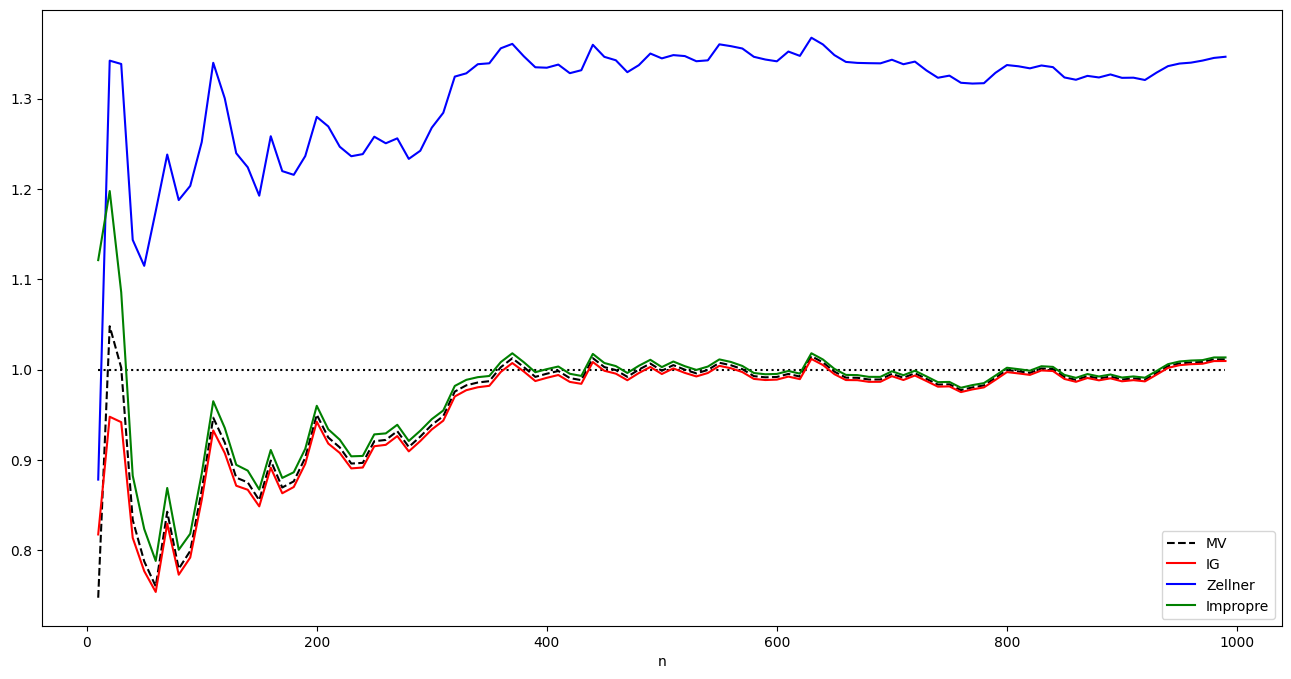

In [47]:
# Paramètres de la simulation
n, p = 1000, 3
beta = np.random.uniform(-5.0, 5.0, p + 1)
sigma2 = 1.0

# Génération des données
Xs, ys = simu_data(n, beta, sigma2, xgen)

# Paramètres de l'étude
a = 2.1
b = 2.0
lbd = 0.01
M = lbd * np.identity(p + 1)
M_inv = np.linalg.inv(M)

# Calculs des estimateurs de la variance
n_grille = np.arange(10, n, 10)
nn = n_grille.shape[0]
sigma2_mv = np.zeros(nn)
sigma2_1 = np.zeros(nn)
sigma2_2 = np.zeros(nn)
sigma2_3 = np.zeros(nn)

for i in range(nn):
    # Données tronquées
    Xn = Xs[: n_grille[i], :]
    yn = ys[: n_grille[i]]
    # Maximum de vraisemblance
    # Q_0 = np.linalg.inv(np.dot(Xn.T, Xn))
    # beta_mv[i, :] = np.dot(
    #     np.dot(Q_0, Xn.T), yn
    # )  # calcul de l'estimateur du maximum de vraisemblance
    beta_mv = np.dot(np.dot(np.linalg.inv(np.dot(Xn.T, Xn)), Xn.T), yn)

    r_mv = yn - np.dot(Xn , beta_mv)  # calcul des résidus

    sigma2_mv[i] = (np.linalg.norm(r_mv) ** 2) / (Xn.shape[0] - Xn.shape[1])  # calcul de l'estimateur de la variance par maximum de vraisemblance

    s_squared = np.linalg.norm(r_mv) ** 2
#     print(s_squared)

    # Inverse gamma
    sigma2_1[i] = (
        2 * b
        + s_squared
        + beta_mv.T
        @ np.linalg.inv(np.linalg.inv(Xn.T @ Xn) + M_inv)
        @ beta_mv
    ) / (2 * a + Xn.shape[0] - 2)

    # Zellner
    sigma2_2[i] = ((1 + lbd) * s_squared + (lbd * beta_mv.T @ (Xn.T @ Xn) @ beta_mv)) / ((1 + lbd) * (Xn.shape[0] - 2))

    # Impropre
    sigma2_3[i] = s_squared /  (Xn.shape[0] - Xn.shape[1] - 2)

# Figure
fig = plt.figure(figsize=(16, 8))
sp = fig.add_subplot(1, 1, 1)
sp.set_xlabel("n")
_ = sp.plot(n_grille, np.full(nn, sigma2), "k:")
_ = sp.plot(n_grille, sigma2_mv, "k--", label="MV")
_ = sp.plot(n_grille, sigma2_1, "r-", label="IG")
_ = sp.plot(n_grille, sigma2_2, "b-", label="Zellner")
_ = sp.plot(n_grille, sigma2_3, "g-", label="Impropre")
_ = sp.legend()


<div class="alert alert-warning"><strong>REPONSE A LA QUESTION IV.1.</strong> <br>
    
- Un  $\lambda$ élevé fait commencer le $\hat{\sigma}_1^2$ loin de la vérité. Pour ce qui est $\hat{\sigma}_2^2$ à faible $\lambda$ on se rapproche de l'estimateur du maximum de vraisemblance  mais avec un $\lambda$ élevé, $\hat{\sigma}_2^2$ reste très loin du $\sigma$ recherché. En effet l'estimateur de Zellner est biasé d'ou cet écart.<br>  
- Un $a$ elévé va sous estimé $\sigma$ tandis qu'un $b$ élevé va le surestimé !
- Cet estimateur semble extrêmement sensible au $\lambda$, il semble shifté vers le haut avec un $\lambda = 0.01$ <br>
- Ces 3 estimateurs sont très similaires. On a $\hat{\sigma}_{\text{MV}}^2$ et $\hat{\sigma}_3^2$ ont presque la même formule ( à une constante près dans le dénominateur). $\hat{\sigma}_1^2$ a une expression plus complexe tend quand même à se confondre avec les deux autres estimateurs.<br>
- Le $\sigma$ permet de quantifier l'erreur sur le $\beta$ mais pas d'estimer $\beta$ en lui même.
</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION IV.2.</strong> Complétez et exécutez le code suivant, puis répondez aux questions.<br/><br/>
    &#9679; Expliquez pourquoi $\hat{\beta}_1$ et $\hat{\beta}_3$ sont si proches. Quel paramètre doit être modifier pour séparer ces deux estimateurs?<br/>
    &#9679; Discutez le comportement de l'estimateur $\hat{\beta}_2$ issu du prior de Zellner, en particulier pour les grandes valeurs de $n$.<br/>
    &#9679; Comparez les trois méthodes lorsque $n$ devient grand.<br/>
    &#9679; Décrivez et expliquez les différences de comportement des estimateurs et des intervalles de crédibilité entre ceux relatifs aux deux premiers coefficients $\beta_0$ et $\beta_1$ et ceux relatifs aux deux derniers coefficients $\beta_2$ et $\beta_3$.<br/>
    &#9679; Pour des petites valeurs de $n$, quel choix de distribution a priori sur $(\beta, \sigma^2)$ semble le plus judicieux compte tenu de ces simulations?</p>

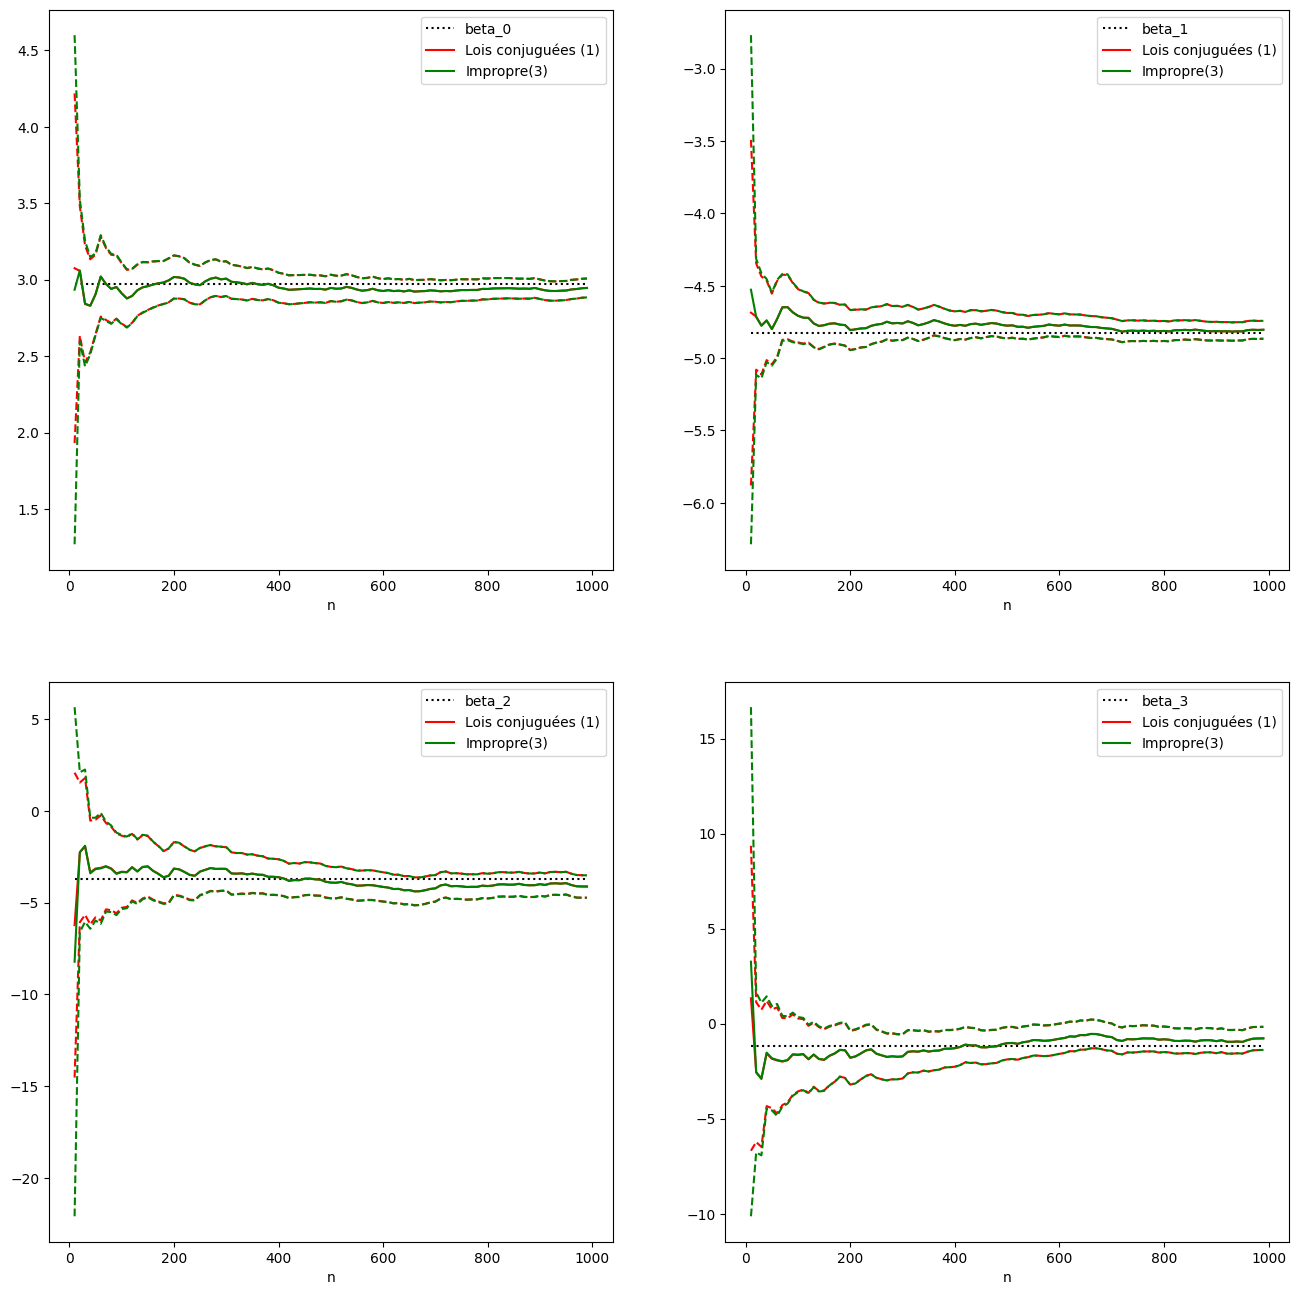

In [53]:
# Paramètres de la simulation
n, p = 1000, 3
beta = np.random.uniform(-5.0, 5.0, p + 1)
sigma2 = 1.0

# Génération des données
Xs, ys = simu_data(n, beta, sigma2, xgen)

# Paramètres de l'étude
a = 2.1
b = 2.0
lbd = 0.01
alpha = 0.05
M = lbd * np.identity(p+1)
M_inv = np.linalg.inv(M)

# Calculs des estimateurs et des intervalles de crédibilité
n_grille = np.arange(10, n, 10)
nn = n_grille.shape[0]
beta_mv = np.zeros((nn, p+1))
beta_1 = np.zeros((nn, p+1))
borne_1 = np.zeros((nn, p+1))
beta_2 = np.zeros((nn, p+1))
borne_2 = np.zeros((nn, p+1))
beta_3 = np.zeros((nn, p+1))
borne_3 = np.zeros((nn, p+1))
for i in range(nn):
    # Données tronquées
    Xn = Xs[:n_grille[i], :]
    yn = ys[:n_grille[i]]
    # Maximum de vraisemblance
    beta_mv[i, :] = np.linalg.inv(Xn.T @ Xn) @ Xn.T @ yn
    r_mv = yn - Xn @ beta_mv[i, :]
    sigma2_mv = (np.linalg.norm(r_mv) ** 2) / (
        Xn.shape[0] - p - 1
    )
    s_squared = np.linalg.norm(r_mv) ** 2
    
    # 1. Lois conjuguées
    beta_1[i, :] = np.linalg.inv(Xn.T @ Xn + M) @ (Xn.T @ Xn @ beta_mv[i, :])
    omega = np.diag(np.linalg.inv(Xn.T @ Xn + M))
    kappa = (
        Xn.shape[0] + 2*a
    ) / (
        2 * b + s_squared
        + beta_mv[i, :].T
        @ np.linalg.inv(np.linalg.inv(Xn.T @ Xn) + M_inv)
        @ beta_mv[i, :].T
    )
        
    psi = ss.t.ppf(1.0 - alpha / 2.0, n_grille[i] + 2*a)
    borne_1[i, :] = psi * np.sqrt(omega / kappa)
    # 2. Zellner
    #beta_2[i, :] = # TO DO
    #omega = # TO DO
    #kappa = # TO DO
    #psi = ss.t.ppf(1.0 - alpha / 2.0, n_grille[i])
    #borne_2[i, :] = psi * np.sqrt(omega / kappa)
    ## 3. Impropre
    beta_3[i, :] = beta_mv[i, :]
    omega = np.diag(np.linalg.inv(Xn.T @ Xn))
    psi = ss.t.ppf(1.0 - alpha / 2.0, n_grille[i] - p - 1)
    borne_3[i, :] = psi * np.sqrt(omega * sigma2_mv)

# Figures
fig = plt.figure(figsize=(16, 16))
for j in range(p + 1):
    sp = fig.add_subplot(2, 2, j+1)
    sp.set_xlabel('n')
    sp.plot(n_grille, np.full(nn, beta[j]), 'k:', label='beta_{}'.format(j))
    sp.plot(n_grille, beta_1[:, j], 'r-', label='Lois conjuguées (1)')
    sp.plot(n_grille, beta_1[:, j] - borne_1[:, j], 'r--')
    sp.plot(n_grille, beta_1[:, j] + borne_1[:, j], 'r--')
    #sp.plot(n_grille, beta_2[:, j], 'b-', label='Zellner (2)')
    #sp.plot(n_grille, beta_2[:, j] - borne_2[:, j], 'b--')
    #sp.plot(n_grille, beta_2[:, j] + borne_2[:, j], 'b--')
    sp.plot(n_grille, beta_3[:, j], 'g-', label='Impropre(3)')
    sp.plot(n_grille, beta_3[:, j] - borne_3[:, j], 'g--')
    sp.plot(n_grille, beta_3[:, j] + borne_3[:, j], 'g--')
    sp.legend()

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION IV.2.</strong> <br>
(N'ayant pas fait la partie optionnelle nous ne pouvons pas réaliser l'estimateur de Zellner) <br>
    
- Ce qui sépare ces deux estimateurs est la matrice $M$ avec $\lambda$,  il faut donc augmenter $\lambda$ pour les séparer
- A $n$ très grand les 2 estimateurs se confondent ($\beta_0$ et $\beta_1$) 
- Les intervalles de confiances diffèrent par les ordres de grandeurs.
- Les lois conjugées semblent le plus pertinent. Les intervalles de confiance semblent plus serrés pour de petites valeurs de $n$. De plus l'estimation de la variance est correct d'après la question précédente
</div>

<h1>V. Applications</h1>

Pour terminer ce BE, nous revenons au jeu de données sur chenilles processionnaires du pin pour lequel nous souhaitons estimer les coefficients de régression par une approche bayésienne et établir des intervalles de crédibilité sur ces coefficients.

<p class="bg-primary" style="padding:1em"><strong>QUESTION V.1.</strong> Compte tenu de tout ce qui précède, quelle méthode d'estimation proposeriez-vous pour le jeu de données sur chenilles processionnaires du pin? Justifiez clairement votre réponse en vous appuyant sur les résultats et simulations obtenus dans le BE.</p>

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION V.1.</strong> Ecrivez votre réponse ICI.</div>

<p class="bg-primary" style="padding:1em"><strong>QUESTION V.2.</strong> Appliquez la méthode choisie à la question précédente et donnez les résultats obtenus.</p>

In [ ]:
# Chargement des données
Xc, yc = caterpillar_data()

# A COMPLETER

<div class="alert alert-warning"><strong>REPONSE A LA QUESTION V.2.</strong> Ecrivez votre réponse ICI.</div>